## Дипломный проект. Бриф учебного кейса
### «Модель прогнозирования стоимости жилья для агентства недвижимости»

Необходимо:
1. Провести разведывательный анализ и очистку исходных данных. Обратите
внимание, что данные в таблице реальные: в результате во многих
признаках присутствуют дублирующиеся категории, ошибки ввода,
жаргонные сокращения и т .д. Вам предстоит отыскать закономерности,
самостоятельно расшифровать все сокращения, найти синонимы в
данных, обработать пропуски и удалить выбросы.
Постарайтесь уделить этапу очистки максимум внимания, так как это
напрямую повлияет на результаты моделирования.
2. Выделить наиболее значимые факторы, влияющие на стоимость
недвижимости.
3. Построить модель для прогнозирования стоимости недвижимости.
4. Разработать небольшой веб-сервис, на вход которому поступают данные
о некоторой выставленной на продажу недвижимости, а сервис
прогнозирует его стоимость.

In [164]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px

In [165]:
# загрузка данных
df = pd.read_csv('data\data.csv')
df.head(3)

,status,private pool,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,mls-id,PrivatePool,MlsId,target
0,Active,NaN,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,NaN,NaN,611019,"$418,000"
1,for sale,NaN,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,NaN,NaN,201916904,"$310,000"
2,for sale,NaN,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,NaN,yes,FR19221027,"$2,895,000"


In [166]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 377185 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337267 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342452 non-null  object
 3   street        377183 non-null  object
 4   baths         270847 non-null  object
 5   homeFacts     377185 non-null  object
 6   fireplace     103114 non-null  object
 7   city          377151 non-null  object
 8   schools       377185 non-null  object
 9   sqft          336608 non-null  object
 10  zipcode       377185 non-null  object
 11  beds          285903 non-null  object
 12  state         377185 non-null  object
 13  stories       226469 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40311 non-null   object
 16  MlsId         310305 non-null  object
 17  target        374704 non-null  object
dtypes: object(18)
memory usa

Описание данных:
* 'status' — статус продажи;
* 'private pool' и 'PrivatePool' — наличие собственного бассейна;
* 'propertyType' — тип объекта недвижимости;
* 'street' — адрес объекта;
* 'baths' — количество ванных комнат;
* 'homeFacts' — сведения о строительстве объекта (содержит несколько
типов сведений, влияющих на оценку объекта);
* 'fireplace' — наличие камина;
* 'city' — город;
* 'schools' — сведения о школах в районе;
* 'sqft' — площадь в футах;
* 'zipcode' — почтовый индекс;
* 'beds' — количество спален;
* 'state' — штат;
* 'stories' — количество этажей;
* 'mls-id' и 'MlsId' — идентификатор MLS (Multiple Listing Service, система
мультилистинга);
* 'target' — цена объекта недвижимости (целевой признак, который
необходимо спрогнозировать).

Важные сведения о данных:
1. Признаки 'homeFacts' и 'schools' представляют собой словари и
содержат несколько типов сведений. Необходимо десериализовать
содержимое этих признаков. Если в нём есть полезные данные,
необходимо создать из них новые признаки.

2. Типы жилья и их основные характеристики (может пригодиться при
обработке признака propertyType):
*  apartment — съёмная квартира (нельзя купить);
* condo — кондоминиум (можно купить);
* co-op — квартира в жилищном кооперативе;
* single-family (detached, tiny home) — односемейный (отдельный,
маленький) дом;
* townhome, townhouse — таунхаус;
* cape cod — черепичная крыша, облицовка деревянным сайдингом,
дверь в центре здания, окна по бокам, один-два этажа;
* colonial home — минимум два этажа, симметрия, лестница в центре
здания, строгий внешний вид;
* contemporary — чистые, простые линии, нейтральные цвета, натуральные
текстуры;
* cottage — небольшая уютная веранда, небольшие жилые помещения;
* craftsman — деревянные элементы ручной работы, выступающие балки,
большие колонны;
* Greek revival — большие белые колонны, украшения в греческом стиле,
нарядный вход;
* farmhouse — прямоугольная планировка, большое крыльцо, амбарная
крыша;
* French country — влияние прованса, облицовка камнем, состаренный
вид;
* Mediterranean — белая штукатурка, дерево и камень в тёплых тонах,
черепичные крыши, элементы испанских и итальянских вилл;
* midcentury modern — сочетание плавных природных и строгих
геометрических линий, гладкость, лаконичность, большие окна;
* ranch — один этаж, низкая крыша, открытые жилые помещения, задний
двор;
* split-level — жилые помещения разделены короткими лестничными
пролётами;
* Tudor — деревянные балки, каменная кладка, асимметричная крутая
двускатная крыша;
* Victorian (Queen Anne Houses) — два-три и более этажей, богатый декор,
крутая двускатная крыша, небольшие башенки, яркий фасад;
* European Houses style — кирпич или камень, высокая крутая крыша,
высокие окна, часто со ставнями, традиционные декоративные детали
(фронтоны, замковые камни);
* log home — деревянный дом.

3. Некоторые жаргонные сокращения — для исправления дублирования
(может пригодиться при обработке признака propertyType):
* 'manufactured home (house)' = 'mobile' = 'prefab' = 'modular';
* 'mobile' = 'mo2 le' = 'mo2le';
* 'cabin' = 'ca2 n' = 'ca2n';
* midcentury = mid century = mid-century;
* single family = single-family home.
4. Некоторые термины, используемые в сфере купли-продажи
недвижимости:
* status — статус, состояние.
* estate — объект недвижимости.
* 'foreclosed' ('foreclosure') — «лишён права выкупа».
Это процесс, когда недвижимость переходит к кредитору из-за
неуплаты ипотеки заёмщиком. Продажа foreclosure-недвижимости
отличается от традиционных продаж.
* 'pre foreclosure' ('pre foreclosure auction') — «до выкупа»,
«аукцион до выкупа».
* 'under contract showing' ('under contract show', 'under
contract', 'active under contract') — предложение о покупке
уже сделано, но не принято продавцом окончательно, и
недвижимость продолжают показывать другим потенциальным
покупателям.
* 'under contract backups', 'active backup', 'backup contract' —
предложение о покупке уже сделано и принято продавцом,
однако он открыт для резервных предложений.
* 'contingency' — дополнительные обстоятельства (критерии,
которым должен соответствовать продавец/покупатель до
завершения сделки).
* 'contingency contract' — контракт на случай возникновения
дополнительных обстоятельств.
* 'active contingency' — сделка уже практически состоялась,
однако продавцу/покупателю для её завершения необходимо
выполнить какие-то условия.
* 'insp inspection contingency' — ситуация, когда покупатель
может официально проинспектировать объект недвижимости в
определённый период времени.
* 'pending escape clause' — договор, предполагающий свободный
выход сторон из него.
* 'pending backup wanted' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям и принимать резервные
предложения.
* 'pending take backups' — условие, предполагающее, что
продавец может принимать резерные предложения, если сделка
с текущим покупателем не состоится.
* 'pending continue show' — договор уже заключен, однако
продавец хочет продолжать показывать недвижимость другим
потенциальным покупателям на случай, если текущая сделка не
состоится.
* 'pending inspection' — «в ожидании инспекции».
* 'due diligence period' — период, в течение которого покупатель
имеет право проинспектировать недвижимость и изучить всю
важную для заключения сделки информацию.
* 'activated' — «активен», открыт для покупки.
* 'active with contract' — продавец уже принял предложение о
покупке, однако сделка ещё не закрыта.
* 'active with offer' — продавец принял предложение о покупке,
однако ищет резервные предложения на случай, если сделка с
текущим покупателем не состоится.
* 'active auction', 'auction active', 'auction' — продажа
недвижимости с помощью аукциона.
* cooling-off period — период, в течение которого покупатель
может расторгнуть договор после завершения сделки.

## Часть I. Анализ и очистка данных

##### Проанализируем имеющиеся у нас данные.

In [167]:
# поиск строк-дубликатов 
dupl = df[df.duplicated()]
dupl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 50 entries, 25418 to 371886
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   status        49 non-null     object
 1   private pool  0 non-null      object
 2   propertyType  50 non-null     object
 3   street        50 non-null     object
 4   baths         20 non-null     object
 5   homeFacts     50 non-null     object
 6   fireplace     3 non-null      object
 7   city          50 non-null     object
 8   schools       50 non-null     object
 9   sqft          23 non-null     object
 10  zipcode       50 non-null     object
 11  beds          22 non-null     object
 12  state         50 non-null     object
 13  stories       8 non-null      object
 14  mls-id        0 non-null      object
 15  PrivatePool   1 non-null      object
 16  MlsId         39 non-null     object
 17  target        49 non-null     object
dtypes: object(18)
memory usage: 7.4+ KB


In [168]:
# удаление строк-дубликатов 
df = df.drop_duplicates(keep='first')
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 377135 entries, 0 to 377184
Data columns (total 18 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   status        337218 non-null  object
 1   private pool  4181 non-null    object
 2   propertyType  342402 non-null  object
 3   street        377133 non-null  object
 4   baths         270827 non-null  object
 5   homeFacts     377135 non-null  object
 6   fireplace     103111 non-null  object
 7   city          377101 non-null  object
 8   schools       377135 non-null  object
 9   sqft          336585 non-null  object
 10  zipcode       377135 non-null  object
 11  beds          285881 non-null  object
 12  state         377135 non-null  object
 13  stories       226461 non-null  object
 14  mls-id        24942 non-null   object
 15  PrivatePool   40310 non-null   object
 16  MlsId         310266 non-null  object
 17  target        374655 non-null  object
dtypes: object(18)
memory usage: 5

<Axes: >

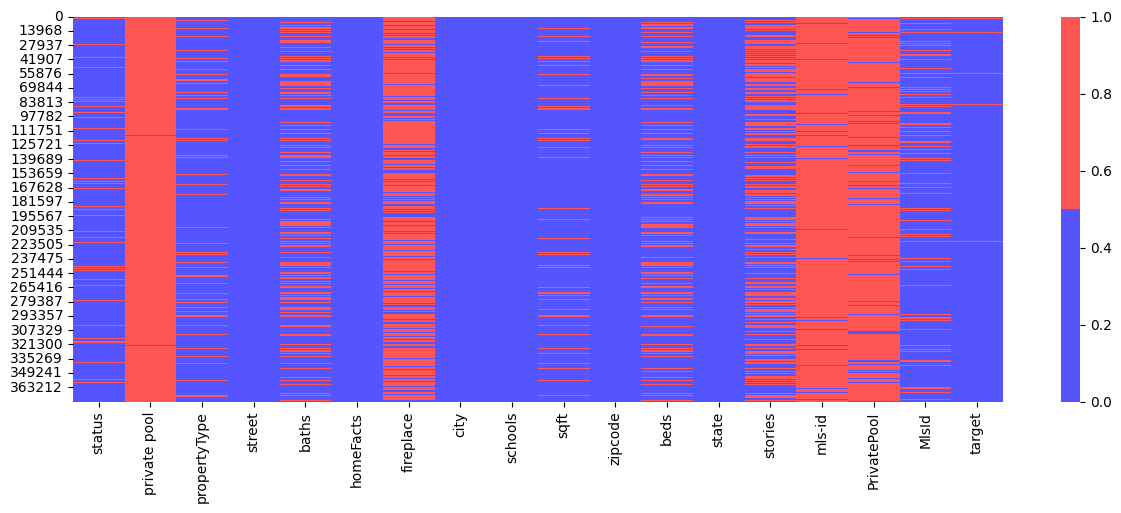

In [169]:
# построим тепловую карту пропущенных значений в признаках
cols = df.columns[:]
# красные - пропущенные данные, синий - не пропущенные
colours = ['#5555FF', '#FF5555'] 
fig, ax = plt.subplots(figsize=(15, 5))
sns.heatmap(df[cols].isnull(), cmap=sns.color_palette(colours))

In [170]:
# поиск признаков, где доля пропусков больше 0.
cols_null_percent = df.isnull().mean() * 100
cols_with_null = round(cols_null_percent[cols_null_percent>0].sort_values(ascending=False),1)
display(cols_with_null)

private pool    98.9
mls-id          93.4
PrivatePool     89.3
fireplace       72.7
stories         40.0
baths           28.2
beds            24.2
MlsId           17.7
sqft            10.8
status          10.6
propertyType     9.2
target           0.7
city             0.0
street           0.0
dtype: float64

Text(0.5, 1.0, 'Гистограмма пропусков в строках')

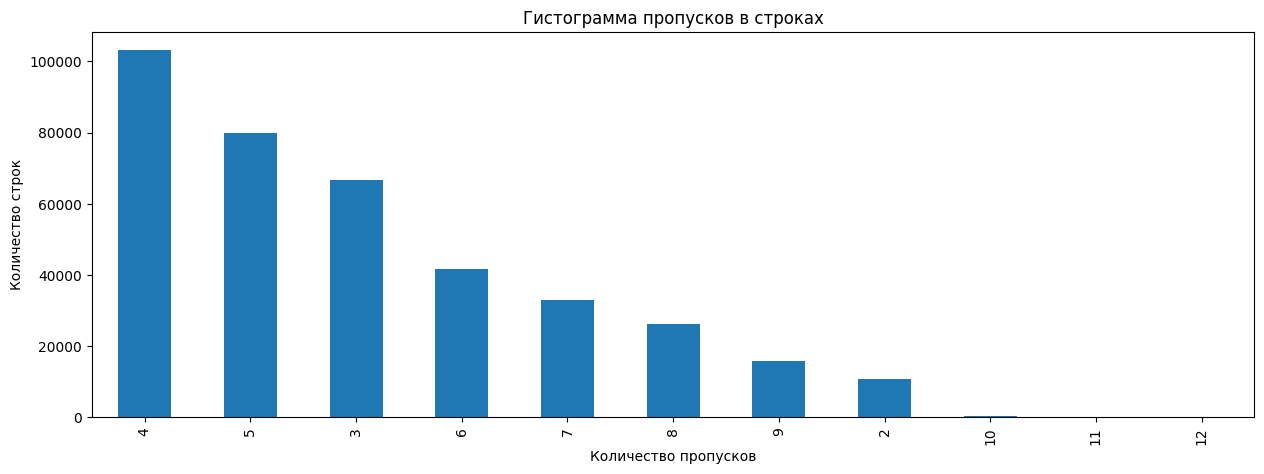

In [171]:
# построим гистограмму, чтобы понять количество пропусков по строкам
# Подсчет количества пропусков по строкам
num_missing = df.isnull().sum(axis=1)
# Построение гистограммы
fig, ax = plt.subplots(figsize=(15, 5))
num_missing.value_counts().plot.bar()
ax.set_xlabel('Количество пропусков')
ax.set_ylabel('Количество строк')
ax.set_title('Гистограмма пропусков в строках')

Как мы видим большая часть данных (около 250 тысяч строк) в строках содержит от 3 до 5 пропусков.

##### Произведем очистку данных

### Бассейны ('privat pool', 'PrivatPool')

##### Несмотря на то, что отсутствии информации о наличии частных бассейнов высока, такие признаки как 'privat pool' и 'PrivatPool' удалять не будем, так как наличие бассейна влияет на стоимость недвижимости. Объединим эти два столбца в один и укажем - Yes, по тем строкам, где имеется бассейн и No - там где бассейна нет. 

In [172]:
# посмотрим на данные признаков 'privat pool' и 'PrivatPool'
print(df['private pool'].value_counts())
print(df['PrivatePool'].value_counts())

private pool
Yes    4181
Name: count, dtype: int64
PrivatePool
yes    28792
Yes    11518
Name: count, dtype: int64


In [173]:
# Данные признаков 'private pool' и 'PrivatePool' обозначим как: наличие - 1 или отсутствие - 0.
df[['private pool']] = df[['private pool']].fillna(0)
df.loc[df['private pool'] != 0, 'private pool'] = 1
df[['PrivatePool']] = df[['PrivatePool']].fillna(0)
df.loc[df['PrivatePool'] != 0, 'PrivatePool'] = 1

# проверка признаков 'private pool' и 'PrivatePool'
print(df['private pool'].value_counts())
print(df['PrivatePool'].value_counts())

private pool
0    372954
1      4181
Name: count, dtype: int64
PrivatePool
0    336825
1     40310
Name: count, dtype: int64


In [174]:
# создаем новый признак 'pool' и вносим в него информацию о наличии (Yes или No) бассейна из столбцов 'private pool' и 'PrivatePool'
def new_pool(pool):
    if pool['private pool'] == 1 or pool['PrivatePool'] == 1:
        return 'Yes'
    else:
        return 'No'

df['pool'] = df.apply(new_pool, axis=1)

# проверка признака 'pool'
df['pool'].value_counts()

pool
No     332644
Yes     44491
Name: count, dtype: int64

In [175]:
# удаление столбцов 'private pool' и 'PrivatePool'
df = df.drop(['private pool', 'PrivatePool'],  axis=1)

### Наличие в базе данных о недвижимости ('mls-id', 'MlsId')

##### Удалим признак 'mls-id' и 'MlsId' (наличие объекта в базе брокеров о недвижимости), так как он не влияет на стоимость недвижимости

In [176]:
# удаление признака 'mls-id' и 'MlsId'
df = df.drop(['mls-id', 'MlsId'],  axis=1)

In [177]:
df.head(3)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Gas Logs,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",No
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",NaN,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",No
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",Yes


### Камин ('fireplace')

##### По признаку 'fireplace' укажем - Yes, по тем строкам, где имеется камин и No - там где камина нет или камин в нерабочем состоянии. 

In [178]:
# Данные признака 'fireplace' приобразуем в наличие - Yes или отсутствие - No.
df['fireplace'] = df['fireplace'].str.replace('Not Applicable', 'No', regex=True)
df[['fireplace']] = df[['fireplace']].fillna(0)
df['fireplace'] = df['fireplace'].replace(0,'No', regex=True)
df['fireplace'] = df['fireplace'].apply(lambda x: 'Yes' if x != 'No' else x)

# проверка признака 'fireplace'
df['fireplace'].value_counts()

fireplace
No     276306
Yes    100829
Name: count, dtype: int64

In [179]:
df.head(3)

,status,propertyType,street,baths,homeFacts,fireplace,city,schools,sqft,zipcode,beds,state,stories,target,pool
0,Active,Single Family Home,240 Heather Ln,3.5,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Yes,Southern Pines,"[{'rating': ['4', '4', '7', 'NR', '4', '7', 'N...",2900,28387,4,NC,NaN,"$418,000",No
1,for sale,single-family home,12911 E Heroy Ave,3 Baths,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",No,Spokane Valley,"[{'rating': ['4/10', 'None/10', '4/10'], 'data...","1,947 sqft",99216,3 Beds,WA,2.0,"$310,000",No
2,for sale,single-family home,2005 Westridge Rd,2 Baths,"{'atAGlanceFacts': [{'factValue': '1961', 'fac...",Yes,Los Angeles,"[{'rating': ['8/10', '4/10', '8/10'], 'data': ...","3,000 sqft",90049,3 Beds,CA,1.0,"$2,895,000",Yes


### Этажность ('stories')

In [180]:
# выведем уникальные значения признака 'stories'
baths_sum = df['stories'].nunique()
print(f'Количество уникальных значений:', baths_sum)
unique_values = df['stories'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['stories'].tail(10))

Количество уникальных значений: 347
Список первых уникальных значений: [nan, '2.0', '1.0', '3.0', 'One', '2', 'Multi/Split', '4.0', '0.0', '0', 'One Level', '1', '9.0', '3', '1 Level, Site Built']
Список последних уникальных значений: 377175    2.0
377176      1
377177    NaN
377178    1.0
377179    3.0
377180    0.0
377181    9.0
377182      2
377183    NaN
377184    1.0
Name: stories, dtype: object


In [181]:
# переведем текстовое значение этажности здания в числовое: 1 - одноэтажное, 2 - двухэтажное, 3 - трехэтажное и более, 0 - без указания этажности.
def new_stories(stories):
    diff_height = ['Acreage', 'Condominium', 'Stories/Levels', 'Traditional', 'Mid-Rise', 'Split Level', 'Total Floors in Bldg', 'Commercial',
'Garden', 'Farm House', 'Other Multi-unit', 'Site Built', 'Contemporary', 'Split Foyer', 'Manufactured Doublewide', 'Unimproved Commercial', 'Cape Cod', ', 2',
'Site Built, Split Foyer', 'Modular Home', 'Mobile', 'Condo', ', 1', 'Manufactured Single wide', 'Farm', 'Ground Level',
'Victorian', 'Colonial', 'Manufactured Singlewide', 'Cabin/Cottage', ', 3', 'Cape', 'Other Style', 'Log Home', 'Craftsman', 'Federal', 'One, Three Or More', 
'1.5 Level, Site Built, Tri-Level', 'Tri/Multi Level', 'Live/Work', 'Site Built, Split Level', 'Condo, Site Built', 'Loft',
'Split Foyer, Tri-Level', 'Cape, Other Style', 'Two, Three Or More', 'Sixplex', '1, 1', 'Apartments', 'Log', 'Hillside', 'Tudor', 'Chalet', 'A Frame', 
'Detached', 'Patio Home', 'T3-Townhouse 3+ Stories', 'Bedroom - Split Plan', 'Manufactured Home, Non-Site Built', 'Quad Level', 'Double Wide',
'1-2 Stories, 3-4 Stories', 'Dwelling Stories', '2 Level, Split Foyer', 'Other, Two, Multi/Split', '1 Story, Split Level', 'Co-op', '1 Level, Site Built, Townhouse']
    two_height = ['2 Stories, Townhouse', '2 Story, Multi Level', '2 Level, Site Built, Townhouse', '1 1/2 Story', 
'2 Story or 2 Level', '2 Levels','Two Story or More', 'Two', '2 Story', '2 Stories',
'2 Level', '2 Story/Basement', '1.5 Story', '2 Level, Site Built', 'Towhouse',
'1.5 Level, Site Built' , '2 Or More Stories', '1.5 Story/Basement', '1.5 Level', 'One and One Half',
'Bi-Level', 'Townhouse' , '1.5 Stories', '2 Level, Condo, Site Built', '1 1/2 Levels', 'Two Stories', '2 Level, Condo', 'Two, Multi/Split', 'Townhouse',
'1-2 Stories', '1.5, 2 ', 'Duplex', '1.5, 2', 'Split Level w/ Sub', '2 Story, Tri Level', '2 Story, Split Level', '2 Level, Site Built, Split Foyer', 'Multi/Split, Two',
'Townhouse-2 Story, T3-Townhouse 3+ Stories', '2 Stories, Tear Down', 'Ground Level, Two', '1 Story, Townhouse', 'Site Built, Townhouse', 'Split Entry (Bi-Level)']
    one_height = ['One', '1 Story' , 'One Story' , '1 Level, Site Built', '1 Level' , 'One story' , 'One Level' , '1 Story/Ranch', 'Ranch/1 Story',
'Ranch', '1 Story Basement', 'Raised Ranch', 'Bungalow','1 Story/F.R.O.G.', '1 Level, Condo, Site Built', '1 Level, Condo', '1 Level, Site Built', 'One, Two',
'1 Level, Non-Site Built', '1 Level, Townhouse', '1 Story, 2 Story', '1 Leveland + Loft', '1 Story, Hillside', 'Ground Level, One', '1 Story, Multi Level',
'1 Level, 2 Level', '1 Level, 1.5 Level', 'Ground Level, Split Level, Two', '1 Level, Split Foyer']
    three_height = ['3 Story/Basement', 'Three Or More', '3 Story', 'Tri-Level', '4 Story', '2.5 Story', '3+', '3 Level, Site Built', 'Multi-Level',
'High-Rise', 'Three Or More Levels', 'Multi-Level', '3+ Story', '3 - 5 Stories', 'Triplex', 'Lot', 'Multi/Split', 'Fourplex', '3-4 Stories',
'6+ Stories', '3 Level, Site Built, Townhouse', '3 Level', 'Condo 5+ Stories', 'Multi-Story', 'Tri Level', 'Three Or More, Multi/Split', '3 Stories',
'3 Level, Townhouse', '3 Level, Condo, Site Built', '3 Levels', '2.5 Story/Basement', '4 Stories', '3 Story, Multi Level', '3 Level, Site Built, Split Level',
'Multi Level, Tri Level', 'Multi Level, Three or More', 'Multi Level', 'Site Built, Tri-Level', 'Multi-Level, New Englander', '3 Level, Site Built, Tri-Level', 
'One and One Half, Three Or More', '3 Story, Tri Level', 'One, Two, Multi/Split']
    if stories['stories'] in two_height:
        return 2
    elif stories['stories'] in one_height:
        return 1
    elif stories['stories'] in three_height:
        return 3    
    elif stories['stories'] in diff_height:
        return 0    
    else:
        return(stories['stories'])

df['stories'] = df.apply(new_stories, axis=1)

In [182]:
# проверим, что тектовых наименований этажей больше нет
df['stories'].value_counts()

stories
1.0       67451
2.0       55283
1         23085
2         18146
3.0       11272
          ...  
16.00         1
1.70          1
78            1
4.0000        1
65.0          1
Name: count, Length: 176, dtype: int64

In [183]:
# переведем в числовой тип информацию об этажности здания
df['stories'] = pd.to_numeric(df['stories'], errors='coerce')

In [184]:
# удаление NaN в 'num_stories'
df[['stories']] = df[['stories']].fillna(0)

In [185]:
# всю информацию об этажности зданиий, кроме тех, где показатель этажности равен 0,  распределим по трем группам:
# 1 - одноэтажное, 2 - двухэтажное, 3 - трехэтажное и более
def nums_stories(n_st):
    one_stories = [1, 1.5, 1.2, 1.3, 1.75, 1.7]
    two_stories = [2, 2.2, 2.5]
    three_stories = range(3,1121)
    if n_st['stories'] in three_stories:
        return 3
    elif n_st['stories'] == 3.5:
        return 3
    elif n_st['stories'] in two_stories:
        return 2
    elif n_st['stories'] in one_stories:
        return 1
    else:
        return n_st['stories']

df['stories'] = df.apply(nums_stories, axis=1)

In [186]:
df['stories'].value_counts()

stories
0.0    163241
1.0    101345
2.0     82897
3.0     29652
Name: count, dtype: int64

### Ванные комнаты ('baths')

In [187]:
# выведем уникальные значения признака 'baths'
baths_sum = df['baths'].nunique()
print(f'Количество уникальных значений:', baths_sum)
unique_values = df['baths'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['baths'].tail(10))

Количество уникальных значений: 229
Список первых уникальных значений: ['3.5', '3 Baths', '2 Baths', '8 Baths', nan, '2', '3', 'Bathrooms: 2', '1,750', '4 Baths', '2 ba', 'Bathrooms: 5', '1,000', '7 Baths', '2.0']
Список последних уникальных значений: 377175    3 Baths
377176        2.0
377177        NaN
377178          2
377179          3
377180        6.0
377181    3 Baths
377182    3 Baths
377183        NaN
377184        2.0
Name: baths, dtype: object


In [188]:
# переведем текстовое значение количества ванных комнат в числовое: 1 - одна, 2 - две, 3 - три и более, 0 - без указания количества.
def new_bath(baths):
    dif_baths = ['Sq. Ft.', '2-1 / 2-1 / 1-1 / 1-1', '1 / 1-0 / 1-0 / 1-0', '~', '0', '0 / 0', '-- baths', '1-0 / 1-0 / 1', '0.00', '—', '0.0','116 / 116 / 116',
'Bathrooms: SemiMod', '3-1 / 2-2', '1 / 1 / 1 / 1', '0.5 Baths', '0.75 Baths', 0]
    two_baths = ['2,000','2.5','2 ba', '2.5 Baths', 'Bathrooms: 2', '2 Baths', 
'2.8 Baths','Two Story or More', 'Two', '2 Story', '2 Stories',
'2 Level', '2 Story/Basement', '1.5 Story', '2 Level, Site Built', 'Towhouse',
'1.5 Level, Site Built' , '2 Or More Stories', '1.5 Story/Basement', '1.5 Level', 'One and One Half',
'Bi-Level', 'Townhouse' , '1.5 Stories', '2 Level, Condo, Site Built', '1 1/2 Levels', 'Two Stories', '2 Level, Condo', 'Two, Multi/Split', 'Townhouse',
'1-2 Stories', '1.5, 2 ', 'Duplex', '1.5, 2', 'Split Level w/ Sub', '2 Story, Tri Level', '2 Story, Split Level', '2 Level, Site Built, Split Foyer', 'Multi/Split, Two',
'Townhouse-2 Story, T3-Townhouse 3+ Stories', '2 Stories, Tear Down', 'Ground Level, Two', '1 Story, Townhouse', 'Site Built, Townhouse', 'Split Entry (Bi-Level)',
'2,250', '2,750', '2.5+', '2.5 ba', '2.75 Baths', '2.25 Baths', '2 baths', '2.25 ba', '2.2 Baths', '2.1 Baths', '2,500', '2', 2, '2.0']
    one_bath = ['One', '1 ba' , '1.75 Baths' , 'Bathrooms: 1', '1-2 Baths' , 'One story' , 'One Level' , '1 Story/Ranch', 'Ranch/1 Story',
'Ranch', '1 Story Basement', 'Raised Ranch', 'Bungalow','1 Story/F.R.O.G.', '1 Level, Condo, Site Built', '1 Level, Condo', '1 Level, Site Built', 'One, Two',
'1 Level, Non-Site Built', '1 Level, Townhouse', '1 Story, 2 Story', '1 Leveland + Loft', '1 Story, Hillside', 'Ground Level, One', '1 Story, Multi Level',
'1 Level, 2 Level', '1 Level, 1.5 Level', 'Ground Level, Split Level, Two', '1 Level, Split Foyer', '1,500', '1,250', '1.5 Baths', '1.5 ba', '1.5+', '1.1 Baths',
'1.75 ba', '1.25 Baths', '1,750', 1, '1', '1,000', '1.0', '1.5']
    three_baths = ['3 Baths', 'Bathrooms: 3', '5 Baths', '4 Baths', '6 Baths ', '2.5 Story', 'Bathrooms: 4', '3.5 Baths', '6 Baths',
'3 ba', '7 Baths', 'Bathrooms: 5', '4 ba', '3.5+', '10 Baths', 'Bathrooms: 7', '4.5+', '5.5+', 'Sq. Ft. ',
'6 ba', '11 Baths', 'Bathrooms: 8', '5.5 Baths', '12 Baths', '10.5 Baths', 'Bathrooms: 27', '68 Baths',
'Bathrooms: 15', '13 ba', '39 Baths', '6.75 Baths', '19 Baths', '7.5 Baths', '32 Baths',
'Bathrooms: 18', 'Bathrooms: 241', 'Bathrooms: 241', '29 Baths', '34 Baths', '42 Baths', 
'5.5 ba', '11.5 Baths', 'Bathrooms: 21', '5.2 Baths', '60 Baths', '3.2 Baths', '11 ba', '8 Baths',
'3.5', '3', '3.0', '4.0', '4.5', '5', '4', '4,000', '3,000', '8.0', '3.5 ba', '5.0', '7.0', '9 Baths',  '6.0', '5.5', '3,500', 'Bathrooms: 6', '4.5 Baths', '750', '6',
'Bathrooms: 19', '10.0', '12 ba', '8', '7.5+', 'Bathrooms: 10', '5 ba', '18 Baths', '7', '18', '5,000', '9', '12.0', '6.5', '10', 'Bathrooms: 9', '16 Baths', '13 Baths',
'Bathrooms: 13', '14', '9.0', '8.5+', '7 ba', '12', 'Bathrooms: 12', '17', '16.0', '10.5+', '8 ba', '6.5+', '6.5 Baths', '14 Baths', '7,500+', '7.5', '11.0', '20 Baths',
'11', '40 Baths', '14.0', '24 Baths', '22.0',  '3.1 Baths', '3.25 Baths', '13', '4.5 ba', '22', '9 ba', '32', '18.0', 'Bathrooms: 11', '17 Baths', '26', '20.0', '9.5', '8.5',
'26 Baths', '15 Baths', '16', '35', '3.75 Baths', '22 Baths',  '40', '21 Baths', '29', '8.5 Baths', '14.5+', '76 Baths', '13.0', '15.0', '23 Baths', '3.3 Baths', '43 Baths',
'21', '20',  '55.0', '3 baths', '25 Baths', '12.5+', 'Bathrooms: 24', '44 Baths', '4.25 Baths', '4.75 Baths', '4.1 Baths', '15', 'Bathrooms: 14', '5.25 Baths', '10 ba', '41.0',
'1.8 Baths', 'Bathrooms: 16', '10.5', '9.5+', '36 Baths', '30 Baths', '27', '12.5', '24.0', '23.0', '24', '28 Baths', '34.0', '64.0', '11.5+', '30', '30.0', '17.0', '16 ba',
'27 Baths', 0, '23', '44.0']
    if baths['baths'] in two_baths:
        return 2
    elif baths['baths'] in one_bath:
        return 1
    elif baths['baths'] in dif_baths:
        return 0
    elif baths['baths'] in three_baths:
        return 3  
    else:
        return(baths['baths'])

df['baths'] = df.apply(new_bath, axis=1)

In [189]:
# удаление NaN в 'baths'
df[['baths']] = df[['baths']].fillna(0)

In [190]:
# проверим признак 'baths'
df['baths'].value_counts()

baths
3.0    120598
2.0    119810
0.0    111530
1.0     25197
Name: count, dtype: int64

#### Спальные комнаты

In [191]:
# выведем уникальные значения признака 'bads'
beds_sum = df['beds'].nunique()
print(f'Количество уникальных значений:', beds_sum)
unique_values = df['beds'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['beds'].tail(10))

Количество уникальных значений: 1184
Список первых уникальных значений: ['4', '3 Beds', '5 Beds', nan, '2 Beds', '3', '4 Beds', '3 bd', 'Baths', '4 bd', '5 bd', '8 Beds', '2', '2 bd', '2.0']
Список последних уникальных значений: 377175        4 Beds
377176             3
377177           NaN
377178             4
377179             2
377180             5
377181        3 Beds
377182        3 Beds
377183    8,479 sqft
377184             3
Name: beds, dtype: object


Так как в признаке 'bads' окло 24% пропусков и нет единой меры, а указано большое разнообразие уникальных значений, таких как количество спален или площадь спален, а также есть нецелые числа, которые обозначают непонятно что, то этот признак мы удалим.

In [192]:
# удаление признака 'beds'
df = df.drop(['beds'],  axis=1)

### Площадь ('sqft')

In [193]:
# выведем уникальные значения признака 'sqft'
sqft_sum = df['sqft'].nunique()
print(f'Количество уникальных значений:', sqft_sum)
unique_values = df['sqft'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['sqft'].tail(10))

Количество уникальных значений: 25405
Список первых уникальных значений: ['2900', '1,947 sqft', '3,000 sqft', '6,457 sqft', nan, '897 sqft', '1,507', '3588', '1,930', '1,300 sqft', '3,130', '2,839 sqft', 'Total interior livable area: 1,820 sqft', '2,454', '2,203']
Список последних уникальных значений: 377175    1,792 sqft
377176    1,829 sqft
377177         1,895
377178         1,841
377179         1,417
377180         4,017
377181    2,000 sqft
377182    1,152 sqft
377183           NaN
377184         1,462
Name: sqft, dtype: object


In [194]:
# Удалим все буквы, пробелы и двоеточия
df['sqft'] = df['sqft'].str.replace('[a-zA-Z:]','', regex=True)
# Удалим все пробелы
df['sqft'] = df['sqft'].str.replace(' ','', regex=True)
# Удалим запятую
df['sqft'] = df['sqft'].str.replace(',','', regex=True)
# Переопределим все остальные нечисловые значения
df['sqft'] = df['sqft'].str.replace('--', '0', regex=True)
df['sqft'] = df['sqft'].str.replace('610-840', '610', regex=True)
# Вместо значения 'NaN' укажем 0
df[['sqft']] = df[['sqft']].fillna(0)
# Переведем в числовой тип
df[['sqft']] = df[['sqft']].astype(int)

In [195]:
# выведем уникальные значения признака 'sqft'
sqft_sum = df['sqft'].nunique()
print(f'Количество уникальных значений:', sqft_sum)
unique_values = df['sqft'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['sqft'].tail(10))
print(f'Средняя площадь:',df['sqft'].median())
print(f'Максимальная площадь:',df['sqft'].max())

Количество уникальных значений: 9896
Список первых уникальных значений: [2900, 1947, 3000, 6457, 0, 897, 1507, 3588, 1930, 1300, 3130, 2839, 1820, 2454, 2203]
Список последних уникальных значений: 377175    1792
377176    1829
377177    1895
377178    1841
377179    1417
377180    4017
377181    2000
377182    1152
377183       0
377184    1462
Name: sqft, dtype: int32
Средняя площадь: 1653.0
Максимальная площадь: 795979430


In [196]:
# Может быть группы не буду использовать
# распределим площадь по группам: 0 - 0 кв., 1 - от 0 до 500 кв, 2 - от 500 до 1000 кв, 3 - от 1000 до 2000, 4 - от 2000 до 4000, 5 - от 4000 до 7500 
# def square(sqft):
#     if 0 < sqft['sqft'] <= 500:
#         return 1
#     elif 500 < sqft['sqft'] <= 1000:
#         return 2
#     elif sqft['sqft'] == 0:
#         return 0
#     elif 1000 < sqft['sqft'] <= 2000:
#         return 3
#     elif 2000 < sqft['sqft'] <= 4000:
#         return 4
#     elif 4000 < sqft['sqft'] <= 7500:
#         return 5
#     elif 7500 < sqft['sqft'] <= 10000:
#         return 6
#     elif 10000 < sqft['sqft'] <= 25000:
#         return 7
#     elif 25000 < sqft['sqft'] <= 50000:
#         return 8
#     elif 50000 < sqft['sqft'] <= 100000:
#         return 9
#     elif 100000 < sqft['sqft'] <= 250000:
#         return 10
#     elif 250000 < sqft['sqft'] <= 500000:
#         return 11
#     elif 500000 < sqft['sqft'] <= 1000000:
#         return 12
#     elif 1000000 < sqft['sqft'] <= 8000000:
#         return 13
#     elif 8000000 < sqft['sqft']:
#         return 14
#     else:
#         return(sqft['sqft'])

# df['sqft'] = df.apply(square, axis=1)

In [197]:
# выведем уникальные значения признака 'sqft'
sqft_sum = df['sqft'].nunique()
print(f'Количество уникальных значений:', sqft_sum)

Количество уникальных значений: 9896


Text(0.5, 0, 'Площадь, миллионов квадратных футов')

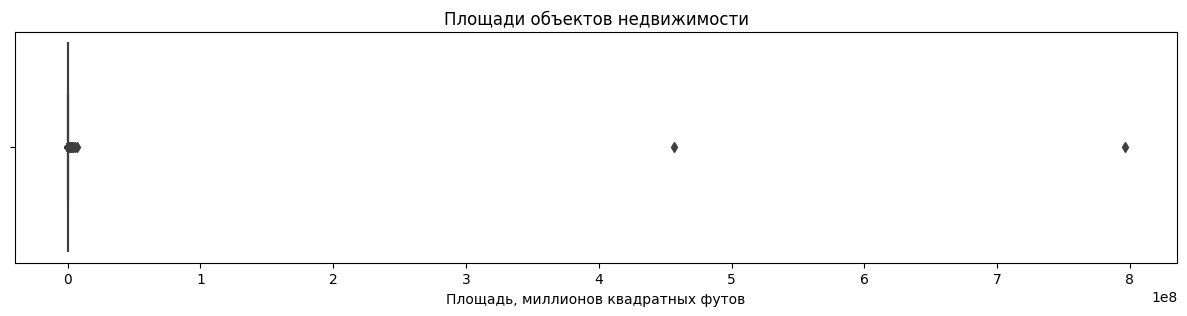

In [198]:
# построим коробчатую диаграмму для признака 'sqft', чтобы увидеть выбросы
fig = plt.figure(figsize=(15,3))
# df.boxplot(column=['sqft'])
boxplot = sns.boxplot(
    data=df,
    x='sqft',
    orient='h',
    width=0.9
)
boxplot.set_title('Площади объектов недвижимости')
boxplot.set_xlabel('Площадь, миллионов квадратных футов')

Проверим объекты площадь которых больше 400 000 000 квадратных футов (около 37 млн.кв.м).

In [199]:
objects = df.loc[df['sqft'] > 400000000, ['sqft', 'street', 'state', 'target']]
display(objects)

,sqft,street,state,target
62736,795979430,1723 Pulte St,OH,"$27,500"
376529,456602479,5382 S Dixie Hwy,KY,"$198,000"


Взглянув на карту google, я обнаружила, что по адресу 1723 Pulte St штата OH находятся маленькие деревянные домишки, а по адресу 5382 S Dixie Hwy штата KY находится кладбище. Удалим эти два объекта, так как по объекту по адресу 1723 Pulte St информация о площади неверная. Кладбища нас не интересуют.

In [200]:
# удаление двух объектов
df = df.loc[df['sqft'] < 400000000]

Text(0.5, 0, 'Площадь, миллионов квадратных футов')

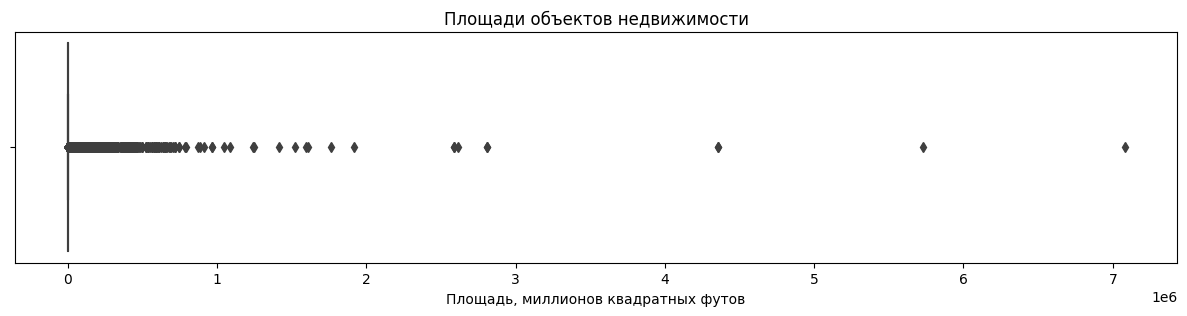

In [201]:
# вновь построим коробчатую диаграмму для признака 'sqft', чтобы увидеть выбросы
fig = plt.figure(figsize=(15,3))
# df.boxplot(column=['sqft'])
boxplot = sns.boxplot(
    data=df,
    x='sqft',
    orient='h',
    width=0.9
)
boxplot.set_title('Площади объектов недвижимости')
boxplot.set_xlabel('Площадь, миллионов квадратных футов')

Проверим объекты площадь которых больше 1 000 000 квадратных футов (около 93 тыс.кв.м).

In [202]:
objects = df.loc[df['sqft'] > 1000000, ['sqft', 'street', 'state', 'target']]
display(objects)

,sqft,street,state,target
4604,1043741,State Highway 30,TX,"$1,200,000"
37394,2585006,23114 Henness Pass,TX,"$138,000"
52217,4356000,22462 Morin Rd,TX,"$2,000,000"
74215,7078574,Out Of Area,TX,"$98,000"
82469,1598652,Fanning Bayou Dr,FL,"$2,500,000"
142148,5728968,Nka Solar Ln,WA,"$289,000"
151007,1524600,35 Country Club Dr,FL,"$210,000"
173320,1916640,18615 Senior Rd,TX,"$660,000"
187391,4356000,100 Old Allanton Rd,FL,"$400,000"
196586,1239282,11800 N Ware Rd,TX,"$4,100,000"


Удалим эти объекты тоже, так как указанная площадь согласно данным из карт google не соответствует действительности.

In [203]:
# удаление объектов, площадь которых свыше 1 000 000 sqft
df = df.loc[df['sqft'] < 1000000]

Text(0.5, 0, 'Площадь, миллионов квадратных футов')

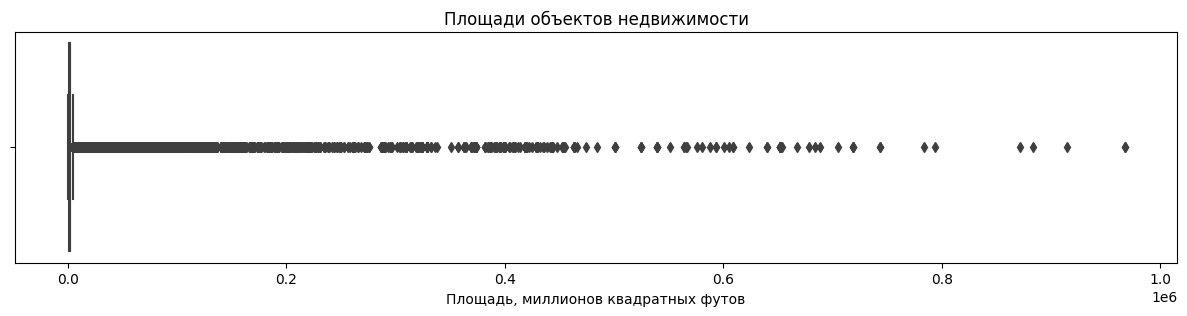

In [204]:
# вновь построим коробчатую диаграмму для признака 'sqft', чтобы увидеть выбросы
fig = plt.figure(figsize=(15,3))
# df.boxplot(column=['sqft'])
boxplot = sns.boxplot(
    data=df,
    x='sqft',
    orient='h',
    width=0.9
)
boxplot.set_title('Площади объектов недвижимости')
boxplot.set_xlabel('Площадь, миллионов квадратных футов')

Проверим объекты площадь которых больше 250 000 квадратных футов (около 23 тыс.кв.м).

In [205]:
objects = df.loc[df['sqft'] > 250000, ['sqft', 'street', 'state', 'target', 'status']]
display(objects)

,sqft,street,state,target,status
318,373772,21015 23rd Ave #6B,NY,"$239,000",for sale
2660,260961,2620 141st St #1E,NY,"$349,990",for sale
2834,332660,3243 91st St #506,NY,"$239,900",for sale
3260,363000,18-35 Corporal Kennedy St #6G,NY,"$269,000",for sale
3902,338373,15 W 81st St #2J,NY,"$1,650,000",for sale
...,...,...,...,...,...
370666,438340,1129 E Axton Rd,WA,"$329,000",for sale
371855,387094,310 E 46th St #19G,NY,"$725,000",for sale
375073,328560,1805 215th St #6J,NY,"$425,000",for sale
375285,444115,3364 21st St #2D,NY,"$475,000",for sale


Посмотрев информацию на карте google об объектах свыше 250 000 кв.футов я решила тоже удалить эти объекты, так как информация о площади явно завышенна.

In [206]:
# удаление объектов, площадь которых свыше 250 000 sqft
df = df.loc[df['sqft'] < 250000]

Так как объектов очень много, а проверять их всех на карте google очень трудоемко, то построим график распределения и коробчатую диаграмму.

Средняя площадь равна 2159 кв.футов.
Предельное значение признака "sqft" составляет 249299 кв.футов.


,sqft
count,376854.000000
mean,2159.012275
std,6245.765019
min,0.000000
25%,1033.000000
50%,1652.000000
75%,2452.000000
max,249299.000000


Численный показатель асимметрии распределения составляет: 24.0.


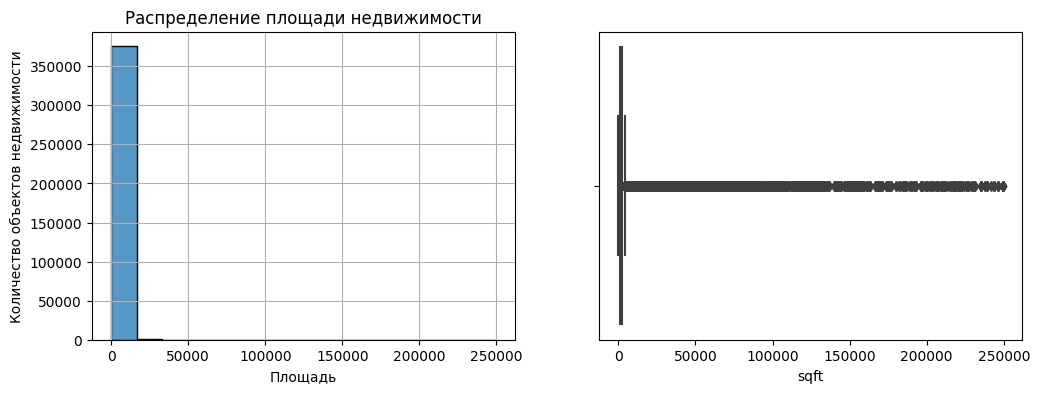

In [207]:
# построим график распределения и коробчатую диаграмму 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=0)

# Построение гистограммы
histplot1 = sns.histplot(
    data=df,
    x='sqft',
    kde=False,
    bins=15,
    ax=axes[0],
)

histplot1.grid()
histplot1.set_title('Распределение площади недвижимости')
histplot1.set_xlabel('Площадь')
histplot1.set_ylabel('Количество объектов недвижимости')

# Построение коробчатой диаграммы
histplot2 = sns.boxplot(
    data=df,
    x='sqft',
    orient='h',
    width=0.9
)

# Расчет средней площади
m_cost = round(df['sqft'].mean())
print(f'Средняя площадь равна {m_cost} кв.футов.')

# Информация о максимальной площади
max_target = df['sqft'].max()
print(f'Предельное значение признака "sqft" составляет {max_target} кв.футов.')

# Статистика признака "sqft"
display(df.describe().loc[:,['sqft']])

# Расчет показателя асимметрии распределения площади
assimetria = np.round(df['sqft'].skew(), decimals = 2)
print(f'Численный показатель асимметрии распределения составляет: {assimetria}.')

Мы видим, что распределение площади даже после удаления объектов недвижимости площадью более 250 000 кв.футов ненормально. Поэтому удалим все объекты площадью свыше 25 000 кв.футов, так как на графике распределения основная часть объектов находится в приделах 25 000 кв.футов. Затем вновь построим график и диаграмму.

In [208]:
df = df.loc[df['sqft'] < 25000]

Средняя площадь равна 1877 кв.футов.
Предельное значение признака "sqft" составляет 24941 кв.футов.


,sqft
count,375685.000000
mean,1876.936617
std,1596.222800
min,0.000000
25%,1030.000000
50%,1650.000000
75%,2443.000000
max,24941.000000


Численный показатель асимметрии распределения составляет: 3.19.


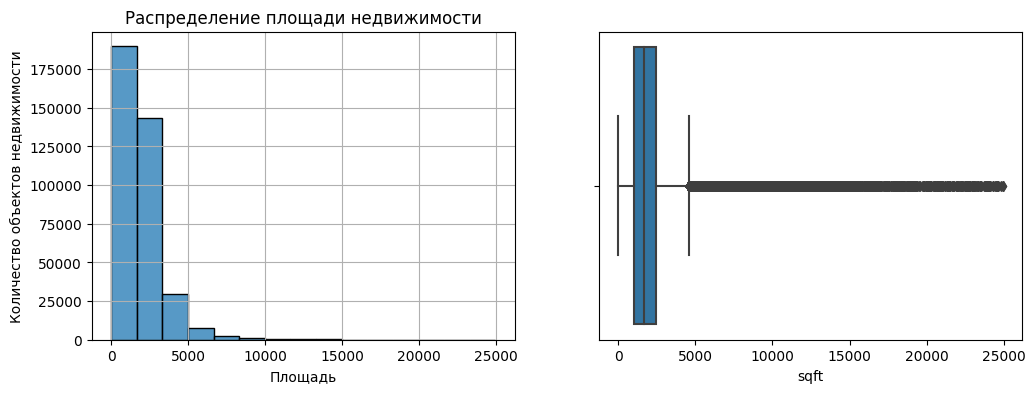

In [209]:
# построим еще раз график распределения и коробчатую диаграмму 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=0)

# Построение гистограммы
histplot1 = sns.histplot(
    data=df,
    x='sqft',
    kde=False,
    bins=15,
    ax=axes[0],
)

histplot1.grid()
histplot1.set_title('Распределение площади недвижимости')
histplot1.set_xlabel('Площадь')
histplot1.set_ylabel('Количество объектов недвижимости')

# Построение коробчатой диаграммы
histplot2 = sns.boxplot(
    data=df,
    x='sqft',
    orient='h',
    width=0.9
)

# Расчет средней площади
m_cost = round(df['sqft'].mean())
print(f'Средняя площадь равна {m_cost} кв.футов.')

# Информация о максимальной площади
max_target = df['sqft'].max()
print(f'Предельное значение признака "sqft" составляет {max_target} кв.футов.')

# Статистика признака "sqft"
display(df.describe().loc[:,['sqft']])

# Расчет показателя асимметрии распределения площади
assimetria = np.round(df['sqft'].skew(), decimals = 2)
print(f'Численный показатель асимметрии распределения составляет: {assimetria}.')

Теперь на коробчатой диаграмме отчетливо видно, что выбросы - это недвижимость площадью свеше 5000 кв.футов. Удалим объекты площадью свыше 10 000 кв.футов.

In [210]:
df = df.loc[df['sqft'] < 10000]

Средняя площадь равна 1823 кв.футов.
Предельное значение признака "sqft" составляет 9999 кв.футов.


,sqft
count,373970.000000
mean,1823.281795
std,1366.700736
min,0.000000
25%,1026.000000
50%,1644.000000
75%,2428.000000
max,9999.000000


Численный показатель асимметрии распределения составляет: 1.4.


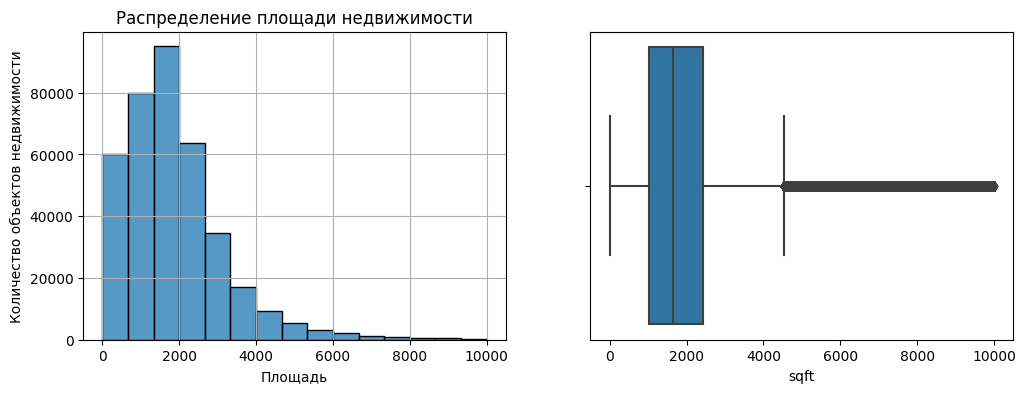

In [211]:
# построим еще раз график распределения и коробчатую диаграмму 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=0)

# Построение гистограммы
histplot1 = sns.histplot(
    data=df,
    x='sqft',
    kde=False,
    bins=15,
    ax=axes[0],
)

histplot1.grid()
histplot1.set_title('Распределение площади недвижимости')
histplot1.set_xlabel('Площадь')
histplot1.set_ylabel('Количество объектов недвижимости')

# Построение коробчатой диаграммы
histplot2 = sns.boxplot(
    data=df,
    x='sqft',
    orient='h',
    width=0.9
)

# Расчет средней площади
m_cost = round(df['sqft'].mean())
print(f'Средняя площадь равна {m_cost} кв.футов.')

# Информация о максимальной площади
max_target = df['sqft'].max()
print(f'Предельное значение признака "sqft" составляет {max_target} кв.футов.')

# Статистика признака "sqft"
display(df.describe().loc[:,['sqft']])

# Расчет показателя асимметрии распределения площади
assimetria = np.round(df['sqft'].skew(), decimals = 2)
print(f'Численный показатель асимметрии распределения составляет: {assimetria}.')

Теперь у нас хорошии графики. Но у нас появились объекты с площадью равной нулю. Удалим такие объекты, так как они будут нам мешать, а заполнить мы их не можем.

In [212]:
df = df.loc[df['sqft'] != 0]

### Статус ('status')

In [213]:
# выведем уникальные значения признака 'status'
status_sum = df['status'].nunique()
print(f'Количество уникальных значений:', status_sum)
unique_values = df['status'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['status'].tail(10))

Количество уникальных значений: 152
Список первых уникальных значений: ['Active', 'for sale', nan, 'New construction', 'For sale', 'Pending', 'P', 'Pre-foreclosure / auction', ' / auction', 'Under Contract', 'Under Contract   Showing', 'Pre-foreclosure', 'Under Contract Backups', 'foreclosure', 'Active Under Contract']
Список последних уникальных значений: 377174    for sale
377175    for sale
377176         NaN
377177      Active
377178         NaN
377179    For sale
377180         NaN
377181    for sale
377182    for sale
377184         NaN
Name: status, dtype: object


In [214]:
# создадим справочники статусов объектов недвижимости 
def status(status):
    # active = ["Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        # "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        # "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        # "Temporary Active", "Re Activated", "Reactivated"]
    sale = ["Active", "A Active", "Active/Contingent", "Active Under Contract", "Active Option", "Auction - Active",
        "Active With Contingencies", "Active Option Contract", "Active Contingency", "Active Backup",
        "Active Contingent", "Active - Auction", "Active With Offer", "Active - Contingent", "Active with Contract",
        "Temporary Active", "Re Activated", "Reactivated", 'For Sale', 'for sale', 'For sale', 'New construction', 'New']
    auction =  ['Auction']
    back_on_market = ['Back on Market', 'Back On Market', 'Accepting backups', 'Backup']
    contingent = ['Contingent', 'Contingent Finance And Inspection', 'Contingent Show',
        'Contingent Take Backup', 'Contingent - Sale of Home', 'Contingent Finance and Inspection',
        'C Continue Show', 'Contingent   Show', 'Contingent   Release', 'Contingent   No Show',
        'CT Insp - Inspection Contingency', 'Contingent   Foreclosure', 'Conting Accpt Backups',
        'Contingent - Financing', 'Contingency 48 Hr (+/ )', 'Contingency Contract', 'Contingent Escape']
    coming_soon = ['Coming soon: Nov 21.', 'Coming soon: Dec 4.', 'Coming soon: Nov 23.', 'Coming soon: Nov 29.',
        'Coming soon: Dec 2.', 'Coming soon: Dec 10.', 'Coming soon: Dec 24.', 'Coming soon: Nov 14.',
        'Coming soon: Nov 22.', 'Coming soon: Oct 21.', 'Coming soon: Dec 14.', 'Coming soon: Oct 24.',
        'Coming soon: Dec 18.', 'Coming soon: Dec 16.', 'Coming soon: Dec 3.', 'Coming soon: Dec 25.',
        'Coming soon: Nov 11.', 'Coming soon: Nov 28.', 'Coming soon: Nov 17.', 'Coming soon: Dec 6.',
        'Coming soon: Nov 27.', 'Coming soon: Nov 26.', 'Coming soon: Dec 7.', 'Coming soon: Dec 27.',
        'Coming soon: Dec 11.', 'Coming soon: Dec 5.', 'Coming soon: Nov 13.', 'Coming soon: Nov 19.',
        'Coming soon: Nov 8.', 'Coming soon: Oct 29.', 'Coming soon: Dec 15.', 'Coming soon: Oct 30.',
        'Coming soon: Dec 9.', 'Coming soon: Dec 20.', 'Coming soon: Dec 13.', 'Coming soon: Dec 23.',
        'Coming soon: Nov 30.', 'Coming soon: Dec 1.', 'Coming soon: Nov 5.', 'Coming soon: Nov 12.',
        'Coming soon: Nov 25.', 'Coming soon: Nov 9.', 'Coming soon: Dec 12.']
    sold = ['Closed', 'Sold: $285,000', 'Sold: $15,000', 'C', 'recently sold']
    foreclosure = ['Pre-foreclosure', 'Pre-foreclosure / auction', ' / auction', 'Foreclosed', 'foreclosure', 'Foreclosure']
    for_rent = ['for rent', 'Apartment for rent', 'Condo for rent']
    listing_extended = ['Listing Extended']
    pending = ['P', 'Pending', 'pending', 'P Pending Sale', 'Pending Ab', 'Pending   Continue To Show', 'Ps',
        'Pending Inspection', 'Pending Offer Approval', 'Pending In', 'Pending W/Insp Finance', 'Pending Fe',
        'Pending W/Backup Wanted', 'Pending Backups Wanted', 'Pending With Contingencies', 'Lease/Purchase Pending',
        'Pending Bring Backup', 'Pending - Taking Backups', 'Pending - Continue to Show', 'Pi', 'Pf',
        'Pending Taking Backups', 'Offer Pending Signature', 'Pending (Do Not Show)', 'Pending W/ Cont.',
        'Pending W/Escape Clause', 'Pending - Backup Offer Requested', 'Pending Sale', 'Option Pending',
        'Pending Sh', 'Pending, Continue to Show', 'Pending   Continue To Show   Financing', 'Pending Take Backups',
        'Pending Continue To Show']
    price_change = ['Price Change']
    lease_purchase = ['Lease/Purchase']
    # sale = ['For Sale', 'for sale', 'For sale', 'New construction', 'New']
    under_contract = ['Under Contract', 'Under Contract   Showing', 'Under Contract Backups', 'Under Contract Show',
        'Under Contract - Show', 'Under Contract - No Show', 'Under contract', 'U Under Contract',
        'Due Diligence Period', 'Contract Contingent On Buyer Sale', 'Contract P', 'Ct', 'Uc Continue To Show',
        'Under Contract Taking Back Up Offers', 'Under Contract W/ Bckp', 'Contract', 'Backup Contract', 'Option Contract', 
       'Conditional Contract', 'Accepted Offer', 'Contingent Lien Holder Release']

    # if status['status'] in active:
    #     return 'active'
    if status['status'] in auction:
        return 'auction'
    elif status['status'] in back_on_market:
        return 'back_on_market'
    elif status['status'] in contingent:
        return 'contingent'
    elif status['status'] in coming_soon:
        return 'coming_soon'
    elif status['status'] in sold:
        return 'sold'
    elif status['status'] in foreclosure:
        return 'foreclosure'
    elif status['status'] in for_rent:
        return 'for_rent'
    elif status['status'] in listing_extended:
        return 'listing_extended'
    elif status['status'] in pending:
        return 'pending' 
    elif status['status'] in price_change:
        return 'price_change'
    elif status['status'] in lease_purchase:
        return 'lease_purchase'
    elif status['status'] in sale:
        return 'sale'
    elif status['status'] in under_contract:
        return 'under_contract' 
    else:
        return(status['status'])

df['status'] = df.apply(status, axis=1)

In [215]:
# Проверим признак 'status'
df['status'].fillna(0).value_counts()

status
sale                262050
0                    36318
foreclosure          10548
pending               6238
under_contract        2870
contingent             928
price_change           456
auction                398
for_rent               390
sold                   326
coming_soon            107
back_on_market         106
listing_extended        10
lease_purchase           1
Name: count, dtype: int64

In [216]:
# удалим строки с нулевым значением в признаке 
df = df.dropna(subset=['status'])

In [217]:
# выведем уникальные значения признака 'status'
print(df['status'].nunique())
df['status'].unique()

13


array(['sale', 'pending', 'foreclosure', 'under_contract', 'for_rent',
       'auction', 'contingent', 'price_change', 'back_on_market', 'sold',
       'coming_soon', 'listing_extended', 'lease_purchase'], dtype=object)

### Тип объекта недвижимости ('propertyType')

In [218]:
# выведем уникальные значения признака 'propertyType'
propertyType_sum = df['propertyType'].nunique()
print(f'Количество уникальных значений:', propertyType_sum)
unique_values = df['propertyType'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['propertyType'].tail(10))

Количество уникальных значений: 1238
Список первых уникальных значений: ['Single Family Home', 'single-family home', 'townhouse', 'Florida', 'coop', 'English', 'Single Family', nan, 'Townhouse', 'multi-family', 'Penthouse, Split-Level', 'Multi-Family Home', 'condo', 'lot/land', ' ']
Список последних уникальных значений: 377170                   Single Family
377171              single-family home
377172                   Single Family
377173              single-family home
377174              single-family home
377175              single-family home
377177    Single Detached, Traditional
377179                           Condo
377181                           condo
377182              single-family home
Name: propertyType, dtype: object


In [219]:
# перевод в нижний регистр
df['propertyType'] = df['propertyType'].str.lower()
df['propertyType'] = df['propertyType'].str.replace('single family home', 'single family', regex=True)
df['propertyType'] = df['propertyType'].str.replace('single-family home', 'single family', regex=True)
df['propertyType'] = df['propertyType'].str.replace('yes','Other', regex=True)
df['propertyType'] = df['propertyType'].str.replace('unknown','Other', regex=True)
# df['propertyType'] = df['propertyType'].str.replace('one', '1', regex=True)

In [220]:
types = {
    'family_home': ['single family', '1 story', '2 story', 'detached', '1 story/ranch', '1 story traditional', 'single detached', 'singlefamilyresidence', 'single wide',
        'single-wide mobile with land', 'two story', 'one story', 'one level unit', 'rancher', '1 1/2 story', 'single wide mh', 'one story traditional', 
        'multi-family', 'multi-family home', 'duplex', 'triplex', 'fourplex', 'multi_level', 'multi family', '2-story'],
    'condo': ['condo', 'coop', 'cooperative', 'condo/townhome/row home/co-op', 'condo/townhome', 'condominium', 'condo/unit', 'apartment/condo/townhouse',
        'co-op', '2 story condo', 'high rise', '2 unit condo'],
    'townhouse': ['townhouse', 'townhome style', 'townhouse-interior', 'townhouse-end unit'],
    'apartment': ['apartment', 'condominium (single level)', 'high-rise', 'mid-rise', 'low-rise (1-3 stories)', 'Flats', 'studio'],
    'land': ['lot/land', 'land'],
    'mobile_home': ['mobile/manufactured', 'mobile / manufactured', 'manufactured house', 'mfd/mobile home', 'mobile home', 'manufactured home', 'manufactured double-wide',
        'manufactured single-wide', 'mobile home 1 story', 'mobile manu - double wide'],
    'ranch': ['ranch',  'hi ranch', 'one story', 'farm house', 'farm/ranch', 'farm/ranch house', 'farms/ranches'],
    'modern': ['contemporary', 'contemporary/modern', "modern", 'mid-century modern', 'modern farmhouse', 'modernist'],
    'historical': ['historical', 'designated historical home', 'historical/conservation district', 'historic/older', 'historic vintage', 'historic'],
    'other': ['1 1/2 story with basement', '1 story with basement', '3 story', '3+ stories', 'attached', 'attached duplex', 'bungalow', 'carriage house',
        'coastal', 'coastal beach home', 'coastal contemporary', 'coastal ii', 'coastal modern', 'coastal two story', 'cottage', 'cottage/camp', 'country english',
        'custom', 'end unit', 'english', 'english manor', 'florida', 'forest garden home', 'garden home',
        'ground floor', 'hi-rise', 'historic', 'historical', 'houseboat', 'key west', 'key west/coastal', 'lake house', 'less than 4 floors', 'loft/balcony',
        'manor', 'manuf/mobile', 'mid-level', 'mid-rise (4-7 stories)', 'miscellaneous', 'mountain contemporary', 'multiple occupancy', 'modular/prefab', 'new build 2019',
        'new englander', 'old style', 'other style', 'patio', 'patio home', 'penthouse', 'post and beam', 'residential (<1 acre)', 'residential (1+ acre)',
        'santa barbara/tuscan', 'split', 'split (4 level)', 'split (5+ level)', 'split foyer', 'split level', 'straight thru', 'texas hill country', 'tudor',
        'urban', 'urban contemporary', 'victorian', 'victorian/federal']
}

def replace_synonyms(value):
    for key, types_values in types.items():
        if value in types_values:
            return key
    return "other"

# Замена синонимов
df['propertyType'] = df['propertyType'].apply(replace_synonyms)

In [221]:
# выведем уникальные значения признака 'propertyType'
propertyType_sum = df['propertyType'].nunique()
print(f'Количество уникальных значений:', propertyType_sum)
unique_values = df['propertyType'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])

Количество уникальных значений: 10
Список первых уникальных значений: ['family_home', 'townhouse', 'other', 'condo', 'land', 'mobile_home', 'apartment', 'modern', 'ranch', 'historical']


### Город ('city')

In [222]:
# выведем уникальные значения признака 'city'
city_sum = df['city'].nunique()
print(f'Количество уникальных значений:', city_sum)
unique_values = df['city'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['city'].tail(10))

Количество уникальных значений: 1816
Список первых уникальных значений: ['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas', 'Philadelphia', 'POINCIANA', 'Mason City', 'Flushing', 'Houston', 'Pembroke Pines', 'Eugene', 'Fort Lauderdale', 'New York', 'Tomball', 'Palmdale']
Список последних уникальных значений: 377170         Las Vegas
377171    Bonita Springs
377172           Sunrise
377173     Fairview Park
377174       San Antonio
377175           Houston
377177        Fort Worth
377179        Washington
377181           Chicago
377182           Jamaica
Name: city, dtype: object


In [223]:
# строки с пропущенным значением в признаке 'city'
cols_null_percent_city = df['city'].isnull().mean()
num = df['city'].isna().sum()
percent_city = cols_null_percent_city * 100

print(f'Процент строк с пропущенным значением в признаке "city":', percent_city)
print(f'Количество строк с пропущенным значением в признаке "city":', round(len(df['city']) * cols_null_percent_city))
print(num)

Процент строк с пропущенным значением в признаке "city": 0.001054748477646364
Количество строк с пропущенным значением в признаке "city": 3
3


In [224]:
# удалим из признака слово 'city'
df['city'] = df['city'].str.replace(' City', '', regex=True)

In [225]:
# выведем уникальные значения признака 'city'
city_sum = df['city'].nunique()
print(f'Количество уникальных значений:', city_sum)
unique_values = df['city'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['city'].tail(10))

Количество уникальных значений: 1808
Список первых уникальных значений: ['Southern Pines', 'Spokane Valley', 'Los Angeles', 'Dallas', 'Philadelphia', 'POINCIANA', 'Mason', 'Flushing', 'Houston', 'Pembroke Pines', 'Eugene', 'Fort Lauderdale', 'New York', 'Tomball', 'Palmdale']
Список последних уникальных значений: 377170         Las Vegas
377171    Bonita Springs
377172           Sunrise
377173     Fairview Park
377174       San Antonio
377175           Houston
377177        Fort Worth
377179        Washington
377181           Chicago
377182           Jamaica
Name: city, dtype: object


In [226]:
# перевод в нижний регистр букв слова, кроме первой буквы
df['city'] = df['city'].str.title()
# удалим строки с пропущенным значением города
df = df.dropna(subset=['city'])

In [227]:
# выведем уникальные значения признака 'city'
city_sum = df['city'].nunique()
print(f'Количество уникальных значений:', city_sum)
# строки с пропущенным значением в признаке 'city'
cols_null_percent_city = df['city'].isnull().mean()
num = df['city'].isna().sum()
percent_city = cols_null_percent_city * 100

print(f'Процент строк с пропущенным значением в признаке "city":', percent_city)
print(f'Количество строк с пропущенным значением в признаке "city":', round(len(df['city']) * cols_null_percent_city))
print(num)

Количество уникальных значений: 1703
Процент строк с пропущенным значением в признаке "city": 0.0
Количество строк с пропущенным значением в признаке "city": 0
0


### Адрес ('street')

In [228]:
# выведем уникальные значения признака 'street'
street_sum = df['street'].nunique()
print(f'Количество уникальных значений:', street_sum)
# строки с пропущенным значением в признаке 'street'
cols_null_percent_street = df['street'].isnull().mean()
num_st = df['street'].isna().sum()
percent_street = cols_null_percent_street * 100

print(f'Процент строк с пропущенным значением в признаке "street":', percent_street)
print(f'Количество строк с пропущенным значением в признаке "street":', round(len(df['street']) * cols_null_percent_street))
print(num_st)
# выведем уникальные значения признака 'street'
unique_values = df['street'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:15])
print(f'Список последних уникальных значений:',df['street'].tail(10))

Количество уникальных значений: 259106
Процент строк с пропущенным значением в признаке "street": 0.0003515865342357388
Количество строк с пропущенным значением в признаке "street": 1
1
Список первых уникальных значений: ['240 Heather Ln', '12911 E Heroy Ave', '2005 Westridge Rd', '4311 Livingston Ave', '1624 S Newkirk St', '552 Casanova Ct ', '11182 Owl Ave', '14205 Roosevelt Ave #512', '4222 False Cypress Ln ', '16373 NW 16th St', '1538 Umpqua Dr', '2402 NW 22nd Rd ', '24 W 126th St ', '22702 Alderdale Ln', '1633 NE 15th St']
Список последних уникальных значений: 377170              6121 Darby Ave
377171          28025 Eagle Ray Ct
377172            2210 NW 70th Ave
377173         19743 N Sagamore Rd
377174           1107 E Euclid Ave
377175            9711 Lawngate Dr
377177        2805 S Jennings Ave 
377179       2238 11th St NW APT 2
377181    3530 N Lake Shore Dr #4B
377182           15509 Linden Blvd
Name: street, dtype: object


In [229]:
# удалим строки с пропущенным значением адреса
df = df.dropna(subset=['street'])

### Школы ('schools')

In [230]:
# выведем уникальные значения признака 'schools'
schools_sum = df['schools'].nunique()
print(f'Количество уникальных значений:', schools_sum)
unique_values = df['schools'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:1])
print(f'Список последних уникальных значений:',df['schools'].tail(5))
print(df['schools'][5])

Количество уникальных значений: 233880
Список первых уникальных значений: ['[{\'rating\': [\'4\', \'4\', \'7\', \'NR\', \'4\', \'7\', \'NR\', \'NR\'], \'data\': {\'Distance\': [\'2.7 mi\', \'3.6 mi\', \'5.1 mi\', \'4.0 mi\', \'10.5 mi\', \'12.6 mi\', \'2.7 mi\', \'3.1 mi\'], \'Grades\': [\'3–5\', \'6–8\', \'9–12\', \'PK–2\', \'6–8\', \'9–12\', \'PK–5\', \'K–12\']}, \'name\': [\'Southern Pines Elementary School\', \'Southern Middle School\', \'Pinecrest High School\', \'Southern Pines Primary School\', "Crain\'s Creek Middle School", \'Union Pines High School\', \'Episcopal Day Private School\', \'Calvary Christian Private School\']}]']
Список последних уникальных значений: 377175    [{'rating': ['2/10', '3/10', '3/10'], 'data': ...
377177    [{'rating': ['4', '6', '5'], 'data': {'Distanc...
377179    [{'rating': ['3/10', '3/10'], 'data': {'Distan...
377181    [{'rating': ['1/10', '5/10', '7/10'], 'data': ...
377182    [{'rating': ['5/10', '4/10'], 'data': {'Distan...
Name: schools, dty

Столбец "школы" ('schools') состоит из словаря, который имеет следующую структуру:
1. Рейтинг
2. Данные:
    - дистанция
    - классы
3. Наименование

Так как стоимость жилья очень зависит от наличия по-соседству хороших школ, то создадим новые столбцы по рейтингу 'max_rating' и 'mean_rating', а также 'mini_distance'  и 'mean_distance' в наших данных. Удалим строки вкоторых отсутствуют данные по рейтингу или дистанции.

In [231]:
# Найдем максимальный рейтинг школы. Пропуски заполним 0.
def mx_rating(rating):
    rating = rating[0].replace('/10', '0/10')
    extracted_numbers =  [float(num) for num in rating if num.isdigit()]
    max_rating = max(extracted_numbers) if extracted_numbers else 0
    return round(max_rating, 1)

# Создадим признак 'shcool_max_rating'
df['school_max_rating'] = (df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: mx_rating(x)))

In [232]:
# Рассчитаем средний рейтинг школ
def mn_rating(rating):
    rating = rating[0].replace('/10', '0/10')
    extracted_numbers = [float(num) for num in rating if num.isdigit()]
    mean_rating = np.average(extracted_numbers) if extracted_numbers else -1
    return round(mean_rating, 1)

# Создадим признак 'shcool_mean_rating'. Пропуски заполним -1 
df['school_mean_rating'] = (df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: mn_rating(x)))

In [233]:
# удалим строки, в котрых отсутствует информация о рейтинге школ
index_rating = df[df['school_mean_rating'] == -1].index
df.drop(index_rating, inplace = True) 

In [234]:
# Найдем минимальную дистанцию до школы. Пропуски заполним -1.
def mini_dist(distance):
    distance = distance[0].replace(' mi', '')
    extracted_numbers =  [float(num) for num in distance if num.isdigit()]
    min_distance = min(extracted_numbers) if extracted_numbers else -1
    return round(min_distance, 1)

# Создадим признак 'shcool_mini_distance'. 
df['school_mini_distance'] = (df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: mini_dist(x)))

In [235]:
# удалим строки, в котрых отсутствует информация о дистанции
index_distance = df[df['school_mini_distance'] == -1].index
df.drop(index_distance, inplace = True) 

In [236]:
# Рассчитаем среднюю дистанцию до школ
def mn_dist(distance):
    distance = distance[0].replace(' mi', '')
    extracted_numbers = [float(num) for num in distance if num.isdigit()]
    mean_distance = np.average(extracted_numbers) if extracted_numbers else 0
    return round(mean_distance, 1)

# Создадим признак 'shcool_mean_distance'. Пропуски заполним 0 
df['shcool_mean_distance'] = (df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b")
    .apply(lambda x: mn_dist(x)))

In [237]:
# создадим новый признак с количеством школ 'school_names_count'
def cnt_schools(name):
    # Разделим строку на названия школ, используя запятые как разделитель
    name = name[0].split(',') 
    # Посчитаем количество школ
    school_count = len(name)
    return school_count

df['school_names_count'] = df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b").apply(lambda x: (cnt_schools(x)))

In [238]:
# так как мне не известно нужен ли будет признак 'school_grades', то я его создам, но из данных пока удалю
def grades_schools(Grades):
    # Разделим строку на названия школ, используя запятые как разделитель
    Grades = Grades[0].split(',') 
    return Grades

df['school_grades'] = df.schools.str.findall(r"\brating': ([\s\S]+?), 'data\b").apply(lambda x: (grades_schools(x)))

In [239]:
# удаление признака 'school_grades'
df = df.drop(columns='school_grades')

In [240]:
# удалим признак 'schools'
df = df.drop(columns='schools')

In [241]:
df.head(2)

,status,propertyType,street,baths,homeFacts,fireplace,city,sqft,zipcode,state,stories,target,pool,school_max_rating,school_mean_rating,school_mini_distance,shcool_mean_distance,school_names_count
0,sale,family_home,240 Heather Ln,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",Yes,Southern Pines,2900,28387,NC,0.0,"$418,000",No,7.0,5.2,4.0,5.2,8
1,sale,family_home,12911 E Heroy Ave,3.0,"{'atAGlanceFacts': [{'factValue': '2019', 'fac...",No,Spokane Valley,1947,99216,WA,2.0,"$310,000",No,4.0,1.0,0.0,1.4,3


### Штат ('state')

In [242]:
# выведем уникальные значения признака 'schools'
state_sum = df['state'].nunique()
print(f'Количество уникальных значений:', state_sum)
unique_values = df['state'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[0:10])
print(f'Список последних уникальных значений:',df['state'].tail(5))

Количество уникальных значений: 35
Список первых уникальных значений: ['NC', 'WA', 'CA', 'TX', 'FL', 'IA', 'NY', 'OR', 'DC', 'NV']
Список последних уникальных значений: 377175    TX
377177    TX
377179    DC
377181    IL
377182    NY
Name: state, dtype: object


### Почтовый индекс ('zipcode)

In [243]:
# выведем уникальные значения признака 'schools'
code_sum = df['zipcode'].nunique()
print(f'Количество уникальных значений:', code_sum)
unique_values = df['zipcode'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[0:10])
print(f'Список последних уникальных значений:',df['zipcode'].tail(5))

Количество уникальных значений: 4340
Список первых уникальных значений: ['28387', '99216', '90049', '75205', '34759', '50401', '11354', '77068', '33028', '97401']
Список последних уникальных значений: 377175    77080
377177    76110
377179    20001
377181    60657
377182    11434
Name: zipcode, dtype: object


In [244]:
# оставим в признаке 'zipcode' первые шесть символов
df['zipcode'] = df['zipcode'].str.slice(0, 6)
# удалим '-'
df['zipcode'] = df['zipcode'].str.replace('-','')

In [245]:
# удалим строки с пустыми значениями
df = df[df['zipcode'] != '']

In [246]:
# переведем признак 'zipcode' в числовой тип
df['zipcode'] = df['zipcode'].astype(int)

### Сведения о строительстве объекта ('homeFacts')
В признаке содержатся такие сведения, как:
1. "Год постройки" ('Year built')
2. "Год реконструкции" ('Remodeled year')
3. "Отопление" ('Heating')
4. "Охлаждение" ('Cooling')
5. "Парковка" ('Parking')
6. "Размер участка" ('lotsize')
7. "Цена/кв. фут"  ('Price/sqft')

In [247]:
# выведем уникальные значения признака 'homeFacts'
homeFacts_sum = df['homeFacts'].nunique()
print(f'Количество уникальных значений:', homeFacts_sum)
unique_values = df['homeFacts'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:1])
print(f'Список последних уникальных значений:',df['homeFacts'].tail(5))

Количество уникальных значений: 263856
Список первых уникальных значений: ["{'atAGlanceFacts': [{'factValue': '2019', 'factLabel': 'Year built'}, {'factValue': '', 'factLabel': 'Remodeled year'}, {'factValue': 'Central A/C, Heat Pump', 'factLabel': 'Heating'}, {'factValue': '', 'factLabel': 'Cooling'}, {'factValue': '', 'factLabel': 'Parking'}, {'factValue': None, 'factLabel': 'lotsize'}, {'factValue': '$144', 'factLabel': 'Price/sqft'}]}"]
Список последних уникальных значений: 377175    {'atAGlanceFacts': [{'factValue': '1970', 'fac...
377177    {'atAGlanceFacts': [{'factValue': '1921', 'fac...
377179    {'atAGlanceFacts': [{'factValue': '2010', 'fac...
377181    {'atAGlanceFacts': [{'factValue': '1924', 'fac...
377182    {'atAGlanceFacts': [{'factValue': '1950', 'fac...
Name: homeFacts, dtype: object


In [248]:
# извлечем названия сведений о строительстве объекта в список
list_factLabel = df['homeFacts'].str.findall(r"\bfactLabel': ([\s\S]+?)[}\b]")
# извлечем данные о строительстве объекта в список
list_factValue = df['homeFacts'].str.findall(r"\bfactValue': ([\s\S]+?), 'factLabel\b")
# создадим новые признаки, используя список названий сведений о строительстве
list_label = ','.join(list_factLabel[0]).replace("'",'').split(',')
# заполним эти признаки значениями из признака 'homeFacts'
for i, val in enumerate(list_label):
    df[val]=list_factValue.apply(lambda x: x[i])

In [249]:
# удалим признак 'homeFacts'
df = df.drop(columns='homeFacts')

### Год постройки ('Year built')

In [250]:
# выведем уникальные значения признака 'Year built'
year_built_sum = df['Year built'].nunique()
print(f'Количество уникальных значений:', year_built_sum)
unique_values = df['Year built'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:10])
print(f'Список последних уникальных значений:',df['Year built'].tail(5))

Количество уникальных значений: 228
Список первых уникальных значений: ["'2019'", "'1961'", "'2006'", "'1970'", "'1965'", "'2015'", "'1996'", "'2008'", "'1899'", "'2016'"]
Список последних уникальных значений: 377175    '1970'
377177    '1921'
377179    '2010'
377181    '1924'
377182    '1950'
Name: Year built, dtype: object


In [251]:
# Удалим ковычки и пустоты
df['Year built'] = df['Year built'].str.replace("'",'', regex=True)
df['Year built'] = df['Year built'].str.replace(" ",'', regex=True)
df['Year built'] = df['Year built'].str.replace("  ",'', regex=True)
# изменим на нижний регистр
df['Year built'] = df['Year built'].str.lower()

In [252]:
df['Year built'] = df['Year built'].replace('nodata', '0')
df['Year built'] = df['Year built'].replace('none', '0')

In [253]:
# Заменим пропуски значением '0'
df['Year built'] = df['Year built'].replace('', '0')

In [254]:
df['Year built'].value_counts()

Year built
2019    25335
0       17343
2006     6968
2005     6495
2007     6073
        ...  
1809        1
1845        1
1807        1
1208        1
1804        1
Name: count, Length: 226, dtype: int64

In [255]:
# Конвертируем столбец Year built в числовой тип данных 
df['Year built'] = df['Year built'].astype(float)

Заполним пропущенные значения в признаке 'Year biult' медианным значением данных, сгруппированных по значению признака 'zipcode', 'city', 'state'

In [256]:
df[df['Year built'] < 1700].value_counts()

status          propertyType  street                            baths  fireplace  city            sqft  zipcode  state  stories  target    pool  school_max_rating  school_mean_rating  school_mini_distance  shcool_mean_distance  school_names_count  Year built  Remodeled year  Heating                  Cooling                             Parking                                                         lotsize          Price/sqft    
sale            family_home   SE 192nd St and  124th Ave SE     3.0    No         Renton          2733  98059    WA     0.0      $635,990  No    5.0                4.2                 3.0                   4.2                   8                   0.0         ''              ''                       ''                                  ''                                                              None             '$233'            3
                other         0 Splashing Rock                  3.0    No         San Antonio     7426  78260    TX     0.0      

In [257]:
# Заменим значения в признаке 'Year built', которые меньше 1700 на медианные значения, сгруппированные по zipcode
df['Year built'] = df.groupby('zipcode')['Year built'].transform(lambda x: x.median() if x.median() >= 1700 else x)
# Для тех объектов, где нет ненулевых значений в группе по zipcode, признак 'Year built' заполним с группировкой по признаку 'city'
df['Year built'] = df.groupby('city')['Year built'].transform(lambda x: x.median() if x.median() >= 1700 else x)
# Для тех объектов, где нет ненулевых значений в группе по zipcode и city, признак 'Year built' заполним с группировкой по признаку 'state'
df['Year built'] = df.groupby('state')['Year built'].transform(lambda x: x.median() if x.median() >= 1700 else x)

In [258]:
df[df['Year built'] < 1700]

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,stories,...,school_mini_distance,shcool_mean_distance,school_names_count,Year built,Remodeled year,Heating,Cooling,Parking,lotsize,Price/sqft
101135,sale,condo,16B 38 N,1.0,No,Playa,555,77720,DE,1.0,...,0.0,1.4,3,0.0,'','Forced air','','','-- sqft lot','$315'
122666,sale,condo,402B 38 N. Gonzalo Guerrero # 402B,1.0,No,Playa,558,77720,DE,1.0,...,0.0,1.4,3,0.0,'','Forced air','','','-- sqft lot','$344'
143930,sale,condo,A506 Flamingo Avenue & 46 N # A506,2.0,No,Playa,3301,77710,DE,2.0,...,0.0,1.4,3,0.0,'','Forced air','','','-- sqft lot','$401'


Удаляем эти два объекта, так как не можем заполнить год строительства. На сайте https://www.zip-codes.com/ по указанным выше адресам zipcode также не определить.

In [259]:
# удаление объектов, по котором нет возможности заполнить zipcode
df = df[df['Year built'] != 0]

In [260]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 281232 entries, 0 to 377182
Data columns (total 24 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                281232 non-null  object 
 1   propertyType          281232 non-null  object 
 2   street                281232 non-null  object 
 3   baths                 281232 non-null  float64
 4   fireplace             281232 non-null  object 
 5   city                  281232 non-null  object 
 6   sqft                  281232 non-null  int32  
 7   zipcode               281232 non-null  int32  
 8   state                 281232 non-null  object 
 9   stories               281232 non-null  float64
 10  target                279774 non-null  object 
 11  pool                  281232 non-null  object 
 12  school_max_rating     281232 non-null  float64
 13  school_mean_rating    281232 non-null  float64
 14  school_mini_distance  281232 non-null  float64
 15  shcoo

### Год реконструкции ('Remodeled year')

In [261]:
# выведем уникальные значения признака 'Year built'
rem_year_sum = df['Remodeled year'].nunique()
print(f'Количество уникальных значений:', rem_year_sum)
unique_values = df['Remodeled year'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:10])
print(f'Список последних уникальных значений:',df['Remodeled year'].tail(5))

Количество уникальных значений: 152
Список первых уникальных значений: ["''", "'1967'", "'2006'", "'2015'", "'1997'", "'2019'", "'2009'", "'2007'", "'1996'", "'1995'"]
Список последних уникальных значений: 377175    '1970'
377177        ''
377179      None
377181        ''
377182    '1950'
Name: Remodeled year, dtype: object


In [262]:
# Удалим ковычки
df['Remodeled year'] = df['Remodeled year'].str.replace("'",'', regex=True)
# изменим на нижний регистр
df['Remodeled year'] = df['Remodeled year'].str.lower()
# уберем значения 'no data' и 'none'
df['Remodeled year'] = df['Remodeled year'].str.replace("no data",'', regex=True)
df['Remodeled year'] = df['Remodeled year'].str.replace("none",'', regex=True)

In [263]:
df['Remodeled year'].value_counts()

Remodeled year
        157705
2006      4733
2005      4009
2007      3544
2008      2911
         ...  
1888         1
1800         1
1897         1
1874         1
1862         1
Name: count, Length: 151, dtype: int64

In [264]:
# если указан год реконструкции, то в признаке укажем Да, при отсутствии года укажем Нет - реконструкции не было.
df['Remodeled year'] = df['Remodeled year'].str.replace('','No', regex=True)
df['Remodeled year'] = df['Remodeled year'].apply(lambda x: 'Yes' if x not in ['No'] else 'No')
# переименуем столбец 'Remodeled year'
df.rename(columns = {'Remodeled year':'Remodeled'}, inplace = True)
df['Remodeled'].value_counts()

Remodeled
No     157705
Yes    123527
Name: count, dtype: int64

### Отопление ('Heating')

In [265]:
# выведем уникальные значения признака 'Heating'
heating_sum = df['Heating'].nunique()
print(f'Количество уникальных значений:', heating_sum)
unique_values = df['Heating'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:7])
print(f'Список последних уникальных значений:',df['Heating'].tail(10))

Количество уникальных значений: 1888
Список первых уникальных значений: ["'Central A/C, Heat Pump'", "''", "'Forced Air'", "'Electric, Heat Pump'", "'Central Electric'", "'Forced air'", "'Other'"]
Список последних уникальных значений: 377170    'Forced air'
377171    'Forced Air'
377172    'Forced air'
377173    'Forced Air'
377174          'Wall'
377175         'Other'
377177              ''
377179    'Forced air'
377181       'Radiant'
377182         'Other'
Name: Heating, dtype: object


In [266]:
# Удалим ковычки
df['Heating'] = df['Heating'].str.replace("'",'', regex=True)
# изменим на нижний регистр
df['Heating'] = df['Heating'].str.lower()
# уберем значения 'no data' и 'none'
df['Heating'] = df['Heating'].str.replace("no data",'', regex=True)
df['Heating'] = df['Heating'].str.replace("none",'', regex=True)

In [267]:
heating_sum = df['Heating'].nunique()
print(f'Количество уникальных значений:', heating_sum)

Количество уникальных значений: 1820


In [268]:
df['Heating'].value_counts()

Heating
forced air                                                                 111096
                                                                            64975
other                                                                       22915
heat pump                                                                    7766
central electric                                                             7024
                                                                            ...  
master closet-tankless                                                          1
both refrigerative & evaporative cooling, refrigeration, ceiling fan(s)         1
pellet                                                                          1
central, combination                                                            1
baseboard, hot water, programmable thermostat, radiant floor                    1
Name: count, Length: 1820, dtype: int64

In [269]:
# укрупним информацию о наличии отопления на "нет" и "да"
df['Heating'] = df['Heating'].str.replace('','No', regex=True)
df['Heating'] = df['Heating'].apply(lambda x: 'Yes' if x not in ['No'] else 'No')

In [270]:
df['Heating'].value_counts()

Heating
Yes    216257
No      64975
Name: count, dtype: int64

### Охлаждение ('Cooling)

In [271]:
# выведем уникальные значения признака 'Cooling'
cooling_sum = df['Cooling'].nunique()
print(f'Количество уникальных значений:', cooling_sum)
unique_values = df['Cooling'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:7])
print(f'Список последних уникальных значений:',df['Cooling'].tail(5))

Количество уникальных значений: 1375
Список первых уникальных значений: ["''", "'Central'", "'Central Air'", "'Central Gas'", "'Central, Evaporative'", "'Has Cooling'", "'Air Conditioning Unit(s), Ceiling Fan(s)'"]
Список последних уникальных значений: 377175                                            'Central'
377177    'Central A/C (Electric), Central Heat (Electric)'
377179                                            'Central'
377181                                                   ''
377182                                                   ''
Name: Cooling, dtype: object


In [272]:
# Удалим ковычки
df['Cooling'] = df['Cooling'].str.replace("'",'', regex=True)
# изменим на нижний регистр
df['Cooling'] = df['Cooling'].str.lower()
# уберем значения 'no data' и 'none'
df['Cooling'] = df['Cooling'].str.replace("no data",'', regex=True)
df['Cooling'] = df['Cooling'].str.replace("none",'', regex=True)

In [273]:
df['Cooling'].value_counts()

Cooling
central                                                                               126658
                                                                                       83014
central air                                                                            14102
has cooling                                                                             8755
central electric                                                                        5880
                                                                                       ...  
central air, electric hot air, heat pump for heat, multi-zone a/c, multi-zone heat         1
forced air heating, radiator heat, wall heat                                               1
air conditioning, dual                                                                     1
dehumidifier                                                                               1
central a/c (gas), central heat (gas), heat pump              

In [274]:
# укрупним информацию о наличии охлождения на "нет" и "да"
df['Cooling'] = df['Cooling'].str.replace('','No', regex=True)
df['Cooling'] = df['Cooling'].apply(lambda x: 'Yes' if x not in ['No'] else 'No')

In [275]:
df['Cooling'].value_counts()

Cooling
Yes    198218
No      83014
Name: count, dtype: int64

### Парковка ('Parking)

In [276]:
# выведем уникальные значения признака 'Parking'
parking_sum = df['Parking'].nunique()
print(f'Количество уникальных значений:', parking_sum)
unique_values = df['Parking'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:7])
print(f'Список последних уникальных значений:',df['Parking'].tail(5))

Количество уникальных значений: 3177
Список первых уникальных значений: ["''", "'Attached Garage'", "'Detached Garage'", "'Carport, Attached Garage'", "'4 spaces'", "'Off Street'", "'None'"]
Список последних уникальных значений: 377175    'Detached Garage'
377177                   ''
377179            '1 space'
377181               'None'
377182                  '2'
Name: Parking, dtype: object


In [277]:
# Удалим ковычки
df['Parking'] = df['Parking'].str.replace("'",'', regex=True)
# изменим на нижний регистр
df['Parking'] = df['Parking'].str.lower()
# уберем значения 'no data' и 'none'
df['Parking'] = df['Parking'].str.replace("no data",'', regex=True)
df['Parking'] = df['Parking'].str.replace("none",'', regex=True)

In [278]:
df['Parking'].value_counts()

Parking
                                                                                                                                    127995
attached garage                                                                                                                      64721
2 spaces                                                                                                                             15941
detached garage                                                                                                                      12169
1 space                                                                                                                               7736
                                                                                                                                     ...  
detached, electric door opener, extnded lngth garage, gated parking, slab parking spaces                                                 1
boat, driveway     

In [279]:
# укрупним информацию о наличии парковочного места на "нет" и "да"
df['Parking'] = df['Parking'].str.replace('','No', regex=True)
df['Parking'] = df['Parking'].apply(lambda x: 'Yes' if x not in ['No'] else 'No')

In [280]:
df['Parking'].value_counts()

Parking
Yes    153237
No     127995
Name: count, dtype: int64

### Размер участка ('lotsize')


In [281]:
# выведем уникальные значения признака 'Lotsize'
lotsize_sum = df['lotsize'].nunique()
print(f'Количество уникальных значений:', lotsize_sum)
unique_values = df['lotsize'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:7])
print(f'Список последних уникальных значений:',df['lotsize'].tail(5))

Количество уникальных значений: 32777
Список первых уникальных значений: ['None', "'5828 sqft'", "'8,626 sqft'", "'8,220 sqft'", "'4,996 Sq. Ft.'", "'124582'", "'1.73 acres'"]
Список последних уникальных значений: 377175       '6,599 sqft'
377177    '7,500 Sq. Ft.'
377179               None
377181                 ''
377182       '1,600 sqft'
Name: lotsize, dtype: object


In [282]:
# Удалим ковычки, запятые, qft и прочее
df['lotsize'] = df['lotsize'].str.replace("'",'', regex=True)
df['lotsize'] = df['lotsize'].str.lower()
df['lotsize'] = df['lotsize'].str.replace(" sqft",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace(" sq. ft.",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace(",",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace("none",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace("no data",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace("—",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace("--",'', regex=True)
df['lotsize'] = df['lotsize'].str.replace("lot",'', regex=True)
df['lotsize'].value_counts()

lotsize
                61447
                 3650
0.26 acres       2326
0.28 acres       1977
0.27 acres       1896
                ...  
13.31 acres         1
107.16 acres        1
7340                1
6.90 acres          1
7084                1
Name: count, Length: 19307, dtype: int64

### Цена/кв. фут  ('Price/sqft')

In [283]:
# Удалим все буквы, пробелы и двоеточия, $ и sqft, прочее
df['Price/sqft'] = df['Price/sqft'].str.lower()
df['Price/sqft'] = df['Price/sqft'].str.replace("none",'', regex=True)
df['Price/sqft'] = df['Price/sqft'].str.replace("no data",'', regex=True)
df['Price/sqft'] = df['Price/sqft'].str.replace("no info",'', regex=True)
df['Price/sqft'] = df['Price/sqft'].str.replace('$', '')
df['Price/sqft'] = df['Price/sqft'].str.replace('sqft', '')
df['Price/sqft'] = df['Price/sqft'].str.replace('sq. ft.', '')
df['Price/sqft'] = df['Price/sqft'].str.replace('/', '')
df['Price/sqft'] = df['Price/sqft'].str.replace("'", '')
df['Price/sqft'] = df['Price/sqft'].str.replace(",", '')
df['Price/sqft'] = df['Price/sqft'].str.replace(" ", '')
df['Price/sqft'].value_counts()

Price/sqft
        7181
123     1525
125     1522
121     1516
128     1515
        ... 
3978       1
2846       1
6598       1
2845       1
1620       1
Name: count, Length: 2910, dtype: int64

##### Так как в признаках 'lotsize' и 'Price/sqft' много пропусков, плюс информация об общей стоимость недвижимость и площадь объекта у нас есть, то эти два признака мы удалим.

In [284]:
# удаление признака 'lotsize' и 'Price/sqft'
df = df.drop(['lotsize', 'Price/sqft'],  axis=1)

In [285]:
df.head(3)

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,stories,...,school_max_rating,school_mean_rating,school_mini_distance,shcool_mean_distance,school_names_count,Year built,Remodeled,Heating,Cooling,Parking
0,sale,family_home,240 Heather Ln,3.0,Yes,Southern Pines,2900,28387,NC,0.0,...,7.0,5.2,4.0,5.2,8,1997.0,No,Yes,No,No
1,sale,family_home,12911 E Heroy Ave,3.0,No,Spokane Valley,1947,99216,WA,2.0,...,4.0,1.0,0.0,1.4,3,1980.5,No,No,No,No
2,sale,family_home,2005 Westridge Rd,2.0,Yes,Los Angeles,3000,90049,CA,1.0,...,8.0,1.9,0.0,2.6,3,1971.0,Yes,Yes,Yes,Yes


### Целевой признак - цена ('target)

In [286]:
# выведем уникальные значения признака 'target'
target_sum = df['target'].nunique()
print(f'Количество уникальных значений:', target_sum)
lost_values_count = df['target'].isna().sum()
print(f'Количество пропущенных значений:', lost_values_count)
percent_lost_target = round(lost_values_count*100/df['target'].count(),2)
print(f'Процент пропущенных значений:', percent_lost_target, '%')
unique_values = df['target'].unique()
a = (list(unique_values))
print(f'Список первых уникальных значений:',a[:10])

Количество уникальных значений: 33658
Количество пропущенных значений: 1458
Процент пропущенных значений: 0.52 %
Список первых уникальных значений: ['$418,000', '$310,000', '$2,895,000', '$2,395,000', '181,500', '$244,900', '$669,000', '260,000', '$525,000', '$499,900']


In [287]:
# Удалим все знаки, двоеточия, $ и прочее
df['target'] = df['target'].str.lower()
df['target'] = df['target'].str.replace('Nan', '', regex=True)
df['target'] = df['target'].str.replace("'", '')
df['target'] = df['target'].str.replace('$', '')
df['target'] = df['target'].str.replace('+', '')
df['target'] = df['target'].str.replace('/mo', '')
df['target'] = df['target'].str.replace(",", '')

In [288]:
# удалим строки с пропущенным значением в признаке 'target'
df = df.dropna(subset=['target'])

In [289]:
# удалю строки с пустым значением и со значением '1215 - 1437' в признаке 'target'
df = df[df['target'] != '1215 - 1437']
df = df[df['target'] != '']

In [290]:
# переведем признак 'target' в числовое значение
df['target'] = df['target'].astype(int)

Средняя стомость равна 596552$.
Предельное значение признака "target" составляет 110000000$.


,target
count,2.797730e+05
mean,5.965524e+05
std,1.266327e+06
min,1.000000e+00
25%,2.105000e+05
50%,3.380000e+05
75%,5.890000e+05
max,1.100000e+08


Численный показатель асимметрии распределения составляет: 17.41.


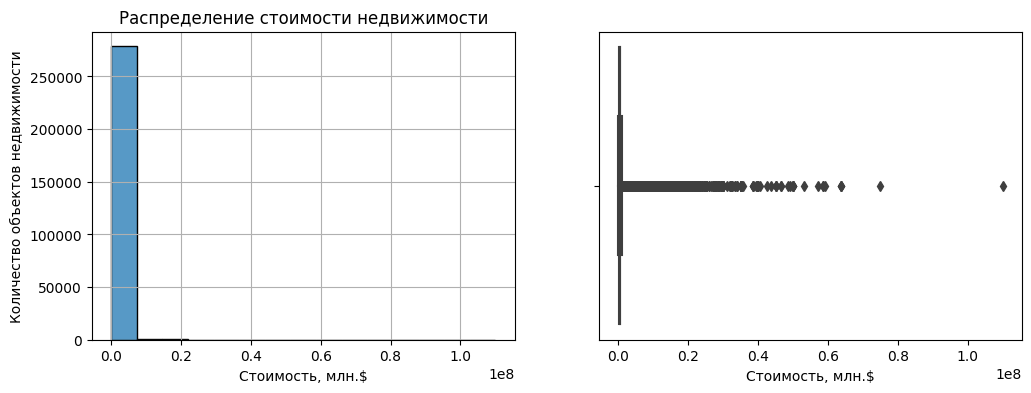

In [291]:
# построим график распределения и коробчатую диаграмму 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=0)

# Построение гистограммы
histplot1 = sns.histplot(
    data=df,
    x='target',
    kde=False,
    bins=15,
    ax=axes[0],
)

histplot1.grid()
histplot1.set_title('Распределение стоимости недвижимости')
histplot1.set_xlabel('Стоимость, млн.$')
histplot1.set_ylabel('Количество объектов недвижимости')

# Построение коробчатой диаграммы
histplot2 = sns.boxplot(
    data=df,
    x='target',
    orient='h',
    width=0.9
)

histplot2.set_xlabel('Стоимость, млн.$')

# Расчет средней площади
m_cost = round(df['target'].mean())
print(f'Средняя стомость равна {m_cost}$.')

# Информация о максимальной площади
max_target = df['target'].max()
print(f'Предельное значение признака "target" составляет {max_target}$.')

# Статистика признака "target"
display(df.describe().loc[:,['target']])

# Расчет показателя асимметрии распределения стоимости
assimetria = np.round(df['target'].skew(), decimals = 2)
print(f'Численный показатель асимметрии распределения составляет: {assimetria}.')

Удалим объекты стоимостью свыше 500 000 $ и построим новые графики.

In [292]:
df = df.loc[df['target'] <= 500000]

Средняя стомость равна 261144$.
Предельное значение признака "target" составляет 500000$.


,target
count,195348.000000
mean,261144.076428
std,120953.010357
min,1.000000
25%,172000.000000
50%,256990.000000
75%,350000.000000
max,500000.000000


Численный показатель асимметрии распределения составляет: 0.03.


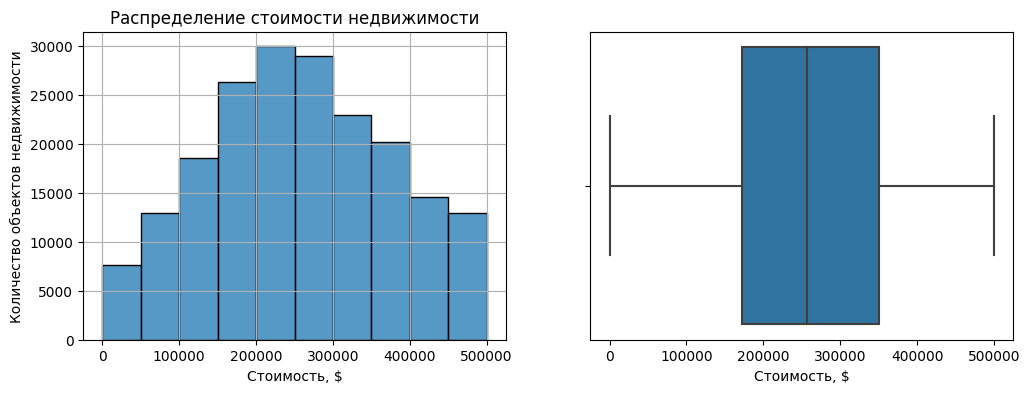

In [293]:
# построим график распределения и коробчатую диаграмму 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
plt.subplots_adjust(hspace=0)

# Построение гистограммы
histplot1 = sns.histplot(
    data=df,
    x='target',
    kde=False,
    bins=10,
    ax=axes[0],
)

histplot1.grid()
histplot1.set_title('Распределение стоимости недвижимости')
histplot1.set_xlabel('Стоимость, $')
histplot1.set_ylabel('Количество объектов недвижимости')

# Построение коробчатой диаграммы
histplot2 = sns.boxplot(
    data=df,
    x='target',
    orient='h',
    width=0.9
)

histplot2.set_xlabel('Стоимость, $')

# Расчет средней площади
m_cost = round(df['target'].mean())
print(f'Средняя стомость равна {m_cost}$.')

# Информация о максимальной площади
max_target = df['target'].max()
print(f'Предельное значение признака "target" составляет {max_target}$.')

# Статистика признака "target"
display(df.describe().loc[:,['target']])

# Расчет показателя асимметрии распределения стоимости
assimetria = np.round(df['target'].skew(), decimals = 2)
print(f'Численный показатель асимметрии распределения составляет: {assimetria}.')

Проверим есть ли объекты с низкой ценой.

In [294]:
# сделаем отбор по параметрам
df.loc[df['target'] < 1000, ['sqft', 'street', 'state', 'target', 'status']]

,sqft,street,state,target,status
15533,1596,1230 Old Dickerson Rd,TN,1,sale
28395,1872,1737 Laurel St,IN,950,for_rent
39559,690,10075 Westpark Dr #77,TX,800,for_rent
42136,1098,E 86th St and Reed Ave,OH,950,for_rent
50662,1656,329 Orange St,NY,600,foreclosure
50984,1400,313 Sherman St,NY,600,foreclosure
73310,2010,1680 Beech St,NV,600,for_rent
82428,804,378 Old Grist Mill Blvd,TN,900,for_rent
84951,2536,7804 Hamilton Ave,OH,1,foreclosure
90321,1176,48 Good St,PA,990,for_rent


Так как 'foreclosure' - это аукцион и окончательная стоимость продажи нам не известна, а 'for_rent' - это сдача недвижимости в аренду, а не продажа, то объекты с такими статусами мы удалим.

In [295]:
# удаление строк по объектам недвижимости со статусами 'for_rent' и 'foreclosure'
df = df.loc[df['status'] != 'for_rent']
df = df.loc[df['status'] != 'foreclosure']

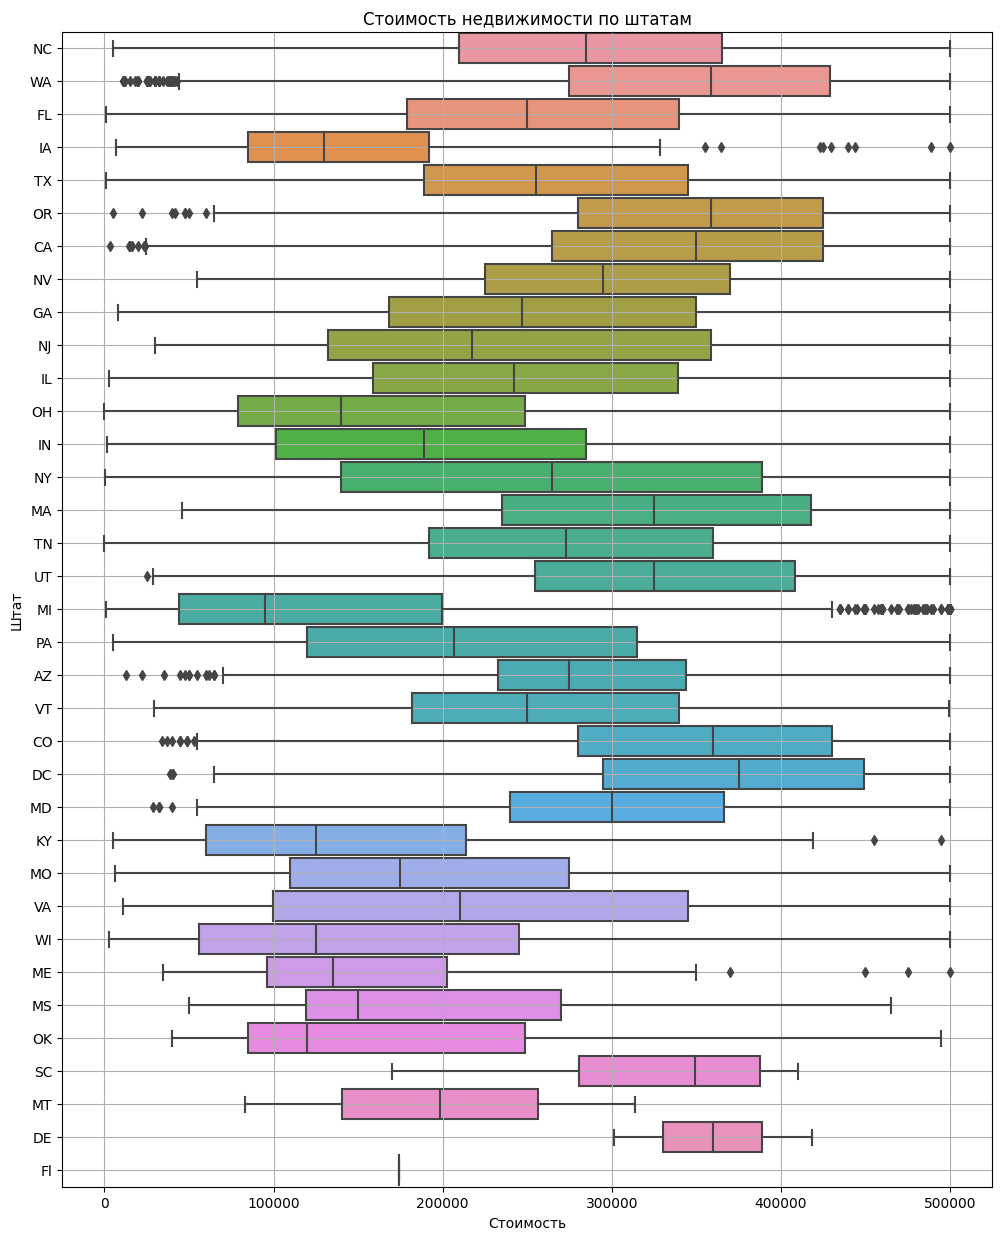

In [296]:
# построим коробчатую диаграмму для признака 'target' в разрезе признака 'state', чтобы увидеть выбросы по штатам
fig = plt.figure(figsize=(12, 15))
boxplot = sns.boxplot(
    data=df,
    y='state',
    x='target',
    orient='h',
    width=0.9
)
# отобразим график
boxplot.set_title('Стоимость недвижимости по штатам');
boxplot.set_xlabel('Стоимость');
boxplot.set_ylabel('Штат');
boxplot.grid()

Далее будем делать отбор и проверку выборсов по следующим штатам: WA, IA, OR, CA, UT, MI, AZ, CO, DC, MD, KY, ME.

In [297]:
# сделаем отбор по параметрам выбросов штата WA
df.loc[(df['state'] == 'WA')&(df['target'] < 60000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
10728,59800,10414 Peacock Hill Ave Spc 56,WA,924
14123,39000,10515 60th Street Ct E Unit 165,WA,1052
16711,32500,3213 28th Street Ct E,WA,1145
19370,20000,4000 Flynn St SPC 136,WA,924
20070,26900,1200 Lincoln St #186,WA,1194
...,...,...,...,...
350346,49000,3001 S 288th St Trlr 391,WA,924
353298,12000,4 Twin Flower Cir,WA,5660
354604,32000,55 W Washington Ave #104,WA,1152
356345,38000,1201 W Washington Ave UNIT 54,WA,1296


Я проверила на сайте https://www.realtor.com/ информацию о ценах по объектам штата WA, которые попали в выбросы. Цены на сайте выше  в 2-10 раз. Поэтому объекты, попавшие в выбросы, действительно содержат недостоверную информацию о ценах. Такие объекты я удалю.

In [298]:
# сделаем удаление по параметрам
df = df.drop(df[(df['state'] == 'WA') & (df['target'] < 60000)].index, axis=0, inplace=False)

In [299]:
# сделаем отбор по параметрам выбросов штата IA
df.loc[(df['state'] == 'IA')&(df['target'] > 340000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
23135,429900,11098 J Ave,IA,3648
32641,444000,20708 Finch Ave,IA,3696
50017,424923,516 Lexington Dr,IA,1846
60128,423000,65 Four Winds Dr,IA,2456
103236,355000,2122 River Rd,IA,1946
211246,439900,1305 Stenberg Dr,IA,1540
227961,364931,1912 N 24th St,IA,2128
229699,489000,212 4th Ave S,IA,3500
265225,499999,2113 S Lakeview Dr,IA,600


Я проверила на сайте https://www.realtor.com/ информацию о ценах по объектам штата IA, которые попали в выбросы. Цены на сайте либо почти соответствуют, либо даже чуть выше. Следовательно объекты, попавшие в выбросы, содержат достоверную информацию о ценах. Такие объекты я оставила.

In [300]:
# сделаем отбор по параметрам выбросов штата OR
df.loc[(df['state'] == 'OR')&(df['target'] < 55000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
10700,47900,3441 SE 111th Ave UNIT 10,OR,672
35002,47900,3441 SE 111th Ave #10,OR,672
193711,49850,17221 SW Eldorado Dr,OR,1236
258805,22500,1930 Hampden Ln NE UNIT 4,OR,924
280135,39900,3500 SE Concord Rd #4,OR,800
286932,5000,1831 N Jantzen Ave,OR,1100
305820,42000,900 NE Francis Ave UNIT 47,OR,980


Я проверила на сайте https://www.realtor.com/ информацию о ценах по объектам штата OR, которые попали в выбросы. Цены на сайте соответствуют. Только по одному объекту цена отличалась на 20%. Следовательно объекты, попавшие в выбросы, содержат достоверную или почти достоверную информацию о ценах. Такие объекты я оставила.

Также я обратила внимание на то, что есть дублирующиеся позиции. Пoэтому признак 'street' нужно доработать.

In [301]:
# переведем буквы в нижний регистр
df['street'] = df['street'].str.lower()
# заменим знак # на UNIT из адреса
df['street'] = df['street'].str.replace('#','unit', regex=True)
df['street'] = df['street'].str.replace('-','', regex=True)

In [302]:
# поиск строк-дубликатов 
dupl = df[df.duplicated(subset=['street', 'state', 'zipcode'])]
dupl.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16109 entries, 549 to 377173
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   status                16109 non-null  object 
 1   propertyType          16109 non-null  object 
 2   street                16109 non-null  object 
 3   baths                 16109 non-null  float64
 4   fireplace             16109 non-null  object 
 5   city                  16109 non-null  object 
 6   sqft                  16109 non-null  int32  
 7   zipcode               16109 non-null  int32  
 8   state                 16109 non-null  object 
 9   stories               16109 non-null  float64
 10  target                16109 non-null  int32  
 11  pool                  16109 non-null  object 
 12  school_max_rating     16109 non-null  float64
 13  school_mean_rating    16109 non-null  float64
 14  school_mini_distance  16109 non-null  float64
 15  shcool_mean_distance 

In [303]:
# удаление строк-дубликатов 
df = df.drop_duplicates(subset=['street', 'state', 'zipcode'], keep='first')

Еще раз построим коробчатую диаграмму стоимости недвижимости по штатам, чтобы продолжит проверку выбросов.

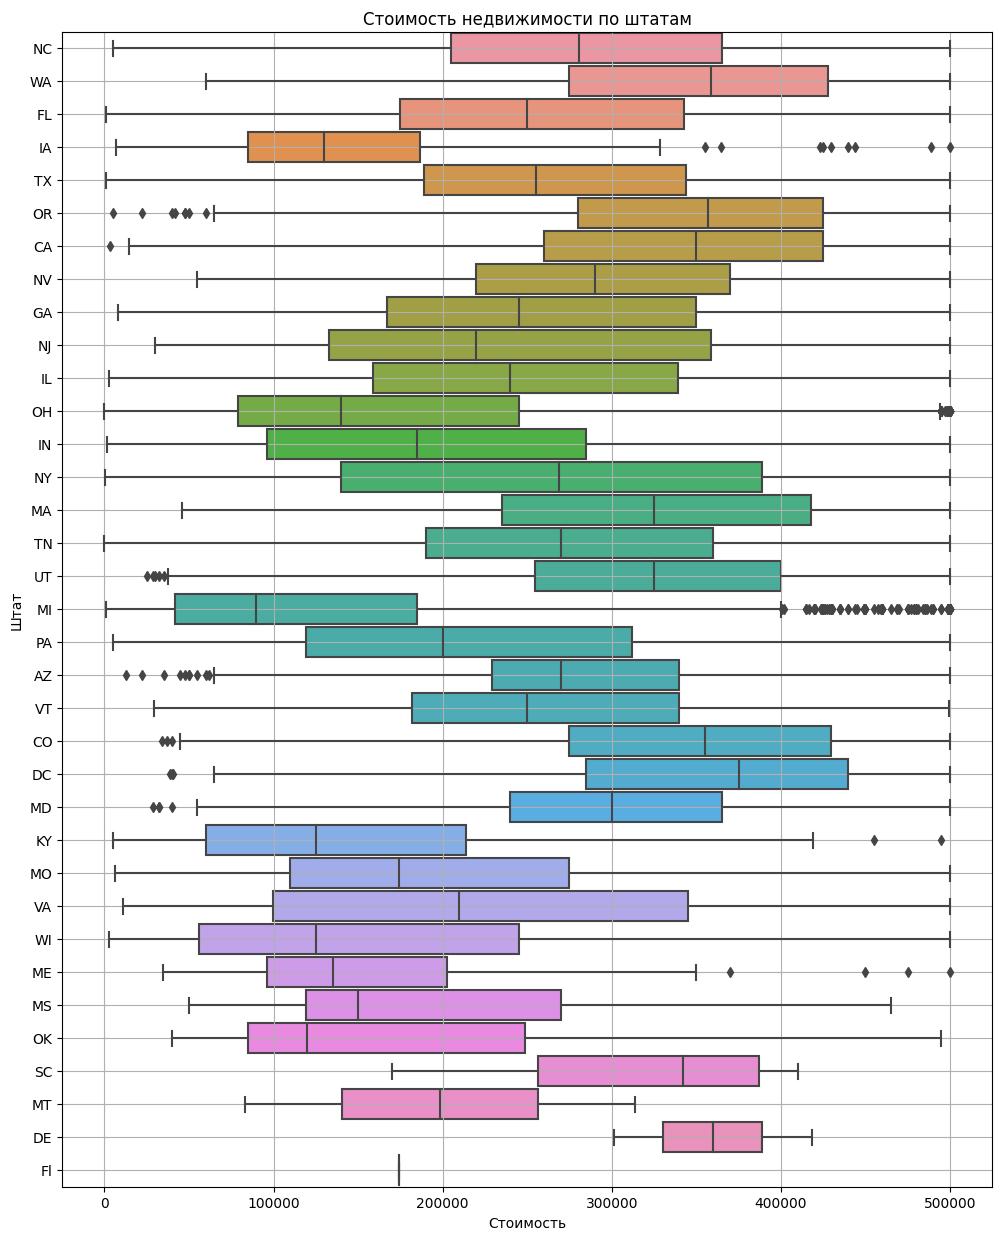

In [304]:
# построим коробчатую диаграмму для признака 'target' в разрезе признака 'state', чтобы увидеть выбросы по штатам
fig = plt.figure(figsize=(12, 15))
boxplot = sns.boxplot(
    data=df,
    y='state',
    x='target',
    orient='h',
    width=0.9
)
# отобразим график
boxplot.set_title('Стоимость недвижимости по штатам');
boxplot.set_xlabel('Стоимость');
boxplot.set_ylabel('Штат');
boxplot.grid()

Продолжу проверку выбросов по штатам.

In [305]:
# сделаем отбор по параметрам выбросов штата СА
df.loc[(df['state'] == 'CA')&(df['target'] < 30000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
37558,25900,260 n lyon ave spc 156,CA,1392
50986,3200,1047 s wooster st,CA,3200
58485,24000,7562 red bud ln,CA,758
70767,14950,601 n kirby st space 154,CA,960
101901,23900,2575 s willow ave unit15,CA,1056
127734,23500,601 n kirby st spc 36,CA,1000
135816,20000,4119 roma ct,CA,5093
186328,29900,18204 soledad canyon rd spc 21,CA,550
249183,14499,43601 florida ave spc 44,CA,504
250646,27000,2500 n state highway 59 spc 65,CA,550


Я проверила на сайте https://www.realtor.com/ информацию о ценах по объектам штата CA, которые попали в выбросы. Цены на сайте на 50% объектов соответствуют, а на другую половину нет. Объектов в выбросах немного, поэтому все их удаляю. 

In [306]:
# сделаем удаление по параметрам
df = df.drop(df[(df['state'] == 'СA') & (df['target'] < 25000)].index, axis=0, inplace=False)

In [307]:
# сделаем отбор по параметрам выбросов штата MI
df.loc[(df['state'] == 'MI')&(df['target'] > 420000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
5451,449000,375 hunters trl,MI,2368
14209,489000,1360 sunset rd,MI,3220
16861,489900,2516 w liberty st,MI,1954
23189,484000,2915 john r st unit212,MI,1587
32827,494900,4233 smokey row,MI,2816
...,...,...,...,...
363074,435000,11447 s west county line rd,MI,4747
370790,425000,21678 bedford rd n,MI,2286
372750,459000,65 s duval rd,MI,2670
373775,475000,8731 s d dr,MI,4140


Проверив цены на сайте https://www.realtor.com/ по объектам штата MI, которые попали в выбросы, пришла к выводы, что эти объекты оставляем, так как цена либо почти соответсвует, либо даже немного выше. 

In [308]:
# сделаем отбор по параметрам выбросов штата AZ
df.loc[(df['state'] == 'AZ')&(df['target'] < 70000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
33785,59900,11411 n 91st ave unit235,AZ,1024
57874,12900,11411 n 91st ave lot 99,AZ,868
114832,65000,16101 n el mirage rd lot 355,AZ,1326
119708,69900,16101 n el mirage rd unit320,AZ,1456
123983,69900,9101 n 65th dr,AZ,840
125033,47500,11411 n 91st ave unit47,AZ,1560
139236,22000,11000 n 91st ave unit90,AZ,1450
171989,49900,5002 w bethany home rd lot 5,AZ,840
190396,35000,2604 w berridge ln unit c110,AZ,482
219273,64900,7200 n 43rd ave lot 38,AZ,1344


Проверив цены на сайте https://www.realtor.com/ по объектам штата AZ, которые попали в выбросы, пришла к выводы, что эти объекты оставляем, так как цена соответсвует. 

In [309]:
# сделаем отбор по параметрам выбросов штата CO
df.loc[(df['state'] == 'CO')&(df['target'] < 55000), ['target', 'street', 'state', 'sqft']]

,target,street,state,sqft
33175,49000,300 w 11th ave unit p84,CO,120
51366,33811,1801 w 92nd ave unit40,CO,924
79475,49000,300 w 11th ave unit p85,CO,120
83809,49000,300 w 11th ave unit p84,CO,120
125432,44900,1801 w 92nd ave unit239,CO,960
134653,39900,860 w 132nd ave unit197,CO,994
154128,37000,3149 brownie cir spc 1,CO,1456
310992,53000,2500 e harmony rd lot 436,CO,1216
325760,44900,1201 w thornton pkwy lot 289,CO,980
350740,44900,2000 w 92nd ave unit239,CO,960


Проверив цены на сайте https://www.realtor.com/ по объектам штата CO, которые попали в выбросы, пришла к выводы, что эти объекты оставляем, так как цена соответсвует. 

In [310]:
# сделаем отбор по параметрам выбросов штата DC
df.loc[(df['state'] == 'DC')&(df['target'] < 65000), ['target', 'street', 'state', 'sqft', 'status']]

,target,street,state,sqft,status
230843,40330,3701 13th st nw unit1,DC,518,sale
250314,38900,4201 cathedral ave nw unit 206,DC,46,sale
278076,40000,936 rhode island ave ne,DC,1398,sale


Проверив цены на сайте https://www.realtor.com/ по объектам штата DC, которые попали в выбросы, пришла к выводы, что эти объекты оставляем, так как цена соответсвует. 

In [311]:
# сделаем отбор по параметрам выбросов штата MD
df.loc[(df['state'] == 'MD')&(df['target'] < 60000), ['target', 'street', 'state', 'sqft', 'status']]

,target,street,state,sqft,status
39309,40000,7248 donnell pl unit c,MD,886,sale
50581,32000,4515 willard ave unit 456p,MD,136,sale
71607,55000,8601 temple hill rd trlr 49,MD,1900,sale
239140,29000,4601 n park ave unit p444,MD,200,sale
286921,59900,3302 huntley square dr apt t3,MD,893,sale
299742,32000,4515 willard ave unit 456p,MD,136,sale


Проверив цены на сайте https://www.realtor.com/ по объектам штата MD, которые попали в выбросы, пришла к выводы, что эти объекты оставляем, так как цена соответсвует. 

In [312]:
# сделаем отбор по параметрам выбросов штата KY
df.loc[(df['state'] == 'KY')&(df['target'] > 410000), ['target', 'street', 'state', 'sqft', 'status']]

,target,street,state,sqft,status
81455,419000,225 faulkner ave,KY,5344,sale
168995,495000,90 shiloh dr,KY,4176,sale
365388,455000,300 faulkner ave,KY,2613,sale


Проверив цены на сайте https://www.realtor.com/ по объектам штата KY, которые попали в выбросы, пришла к выводы, что эти объекты надо удалить, так как два последних невозможно идентифицировать, а по первому объекту цена значительно ниже.

In [313]:
# сделаем удаление по параметрам
df = df.drop(df[(df['state'] == 'KY') & (df['target'] > 410000)].index, axis=0, inplace=False)

In [314]:
# сделаем отбор по параметрам выбросов штата ME
df.loc[(df['state'] == 'ME')&(df['target'] > 350000), ['target', 'street', 'state', 'sqft', 'status', 'zipcode']]

,target,street,state,sqft,status,zipcode
16642,449900,24 wedgewood dr,ME,5906,sale,4963
47194,475000,23 libby hill rd,ME,3500,sale,4963
107330,369900,22 meadow dr,ME,2816,pending,4963
291342,499900,32 w sandy river rd,ME,1860,sale,4957


Проверив цены на сайте https://www.realtor.com/ по объектам штата ME, которые попали в выбросы, пришла к выводы, что эти объекты оставляем, так как цена либо меньше на 10%, либо выше на 20%. 

Посмотрим как выглядит таблица с очищенными данными

In [315]:
df

,status,propertyType,street,baths,fireplace,city,sqft,zipcode,state,stories,...,school_max_rating,school_mean_rating,school_mini_distance,shcool_mean_distance,school_names_count,Year built,Remodeled,Heating,Cooling,Parking
0,sale,family_home,240 heather ln,3.0,Yes,Southern Pines,2900,28387,NC,0.0,...,7.0,5.2,4.0,5.2,8,1997.0,No,Yes,No,No
1,sale,family_home,12911 e heroy ave,3.0,No,Spokane Valley,1947,99216,WA,2.0,...,4.0,1.0,0.0,1.4,3,1980.5,No,No,No,No
6,sale,other,552 casanova ct,0.0,No,Poinciana,1507,34759,FL,1.0,...,3.0,2.3,1.0,2.3,4,1990.0,Yes,Yes,Yes,No
8,sale,family_home,11182 owl ave,2.0,No,Mason,3588,50401,IA,0.0,...,7.0,3.8,2.0,3.8,6,1961.0,No,Yes,Yes,No
11,sale,other,4222 false cypress ln,0.0,No,Houston,3130,77068,TX,2.0,...,6.0,4.2,1.0,4.2,5,1990.0,Yes,Yes,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
377170,sale,family_home,6121 darby ave,3.0,Yes,Las Vegas,2672,89146,NV,2.0,...,5.0,1.2,0.0,1.7,3,1998.0,Yes,Yes,Yes,Yes
377171,sale,family_home,28025 eagle ray ct,3.0,No,Bonita Springs,2022,34135,FL,1.0,...,8.0,1.6,0.0,2.2,24,1990.0,Yes,Yes,Yes,Yes
377172,sale,family_home,2210 nw 70th ave,2.0,No,Sunrise,1907,33313,FL,1.0,...,6.0,1.2,0.0,1.7,3,1990.0,Yes,Yes,Yes,Yes
377175,sale,family_home,9711 lawngate dr,3.0,Yes,Houston,1792,77080,TX,2.0,...,3.0,0.9,0.0,1.2,3,1990.0,Yes,Yes,Yes,Yes


In [316]:
# еще раз проверим признаки на наличие в них пропусков
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

status - 0%
propertyType - 0%
street - 0%
baths - 0%
fireplace - 0%
city - 0%
sqft - 0%
zipcode - 0%
state - 0%
stories - 0%
target - 0%
pool - 0%
school_max_rating - 0%
school_mean_rating - 0%
school_mini_distance - 0%
shcool_mean_distance - 0%
school_names_count - 0%
Year built - 0%
Remodeled - 0%
Heating - 0%
Cooling - 0%
Parking - 0%


Признаков с пропусками нет.

Произведем исследование логарифмированных распределений на наличие выбросов с помощью метода z-отклонений (3ех сигм)

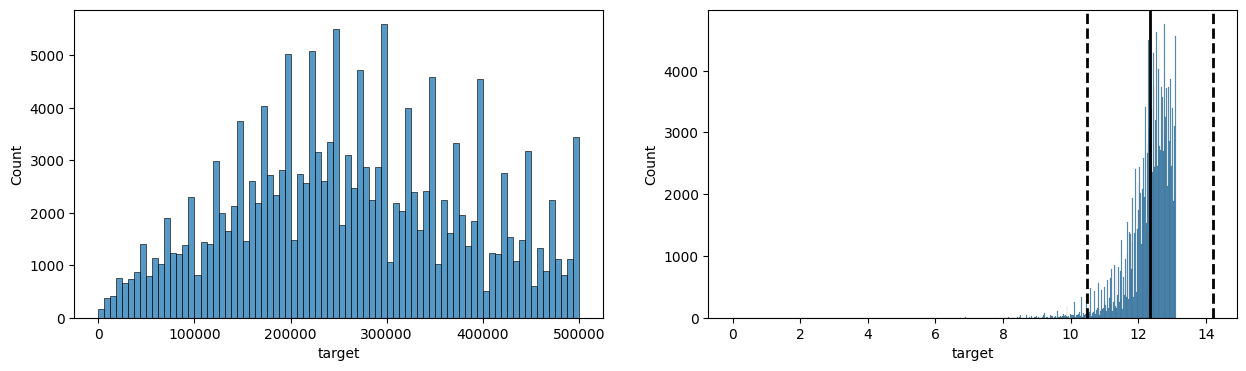

In [317]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4)) #фигура + координатная плоскость
#Строим гистограмму
sns.histplot(data=df, x='target', ax=axes[0]);
#Логарифмируем
log_target = np.log(df['target'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='k', ls='--', lw=2);

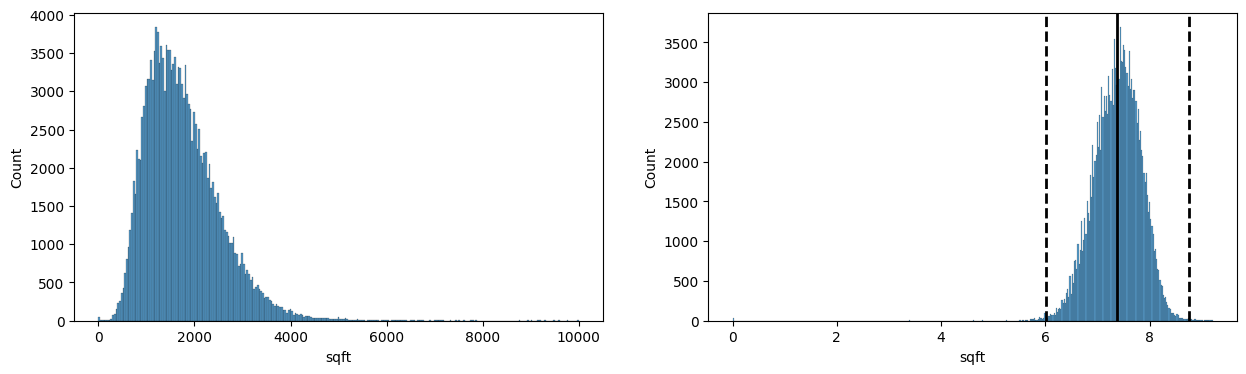

In [318]:
#Строим гистограмму
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df, x='sqft', ax=axes[0]);
#Логарифмируем
log_target = np.log(df['sqft'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='k', ls='--', lw=2);

c:\Users\tani_\AppData\Local\Programs\Python\Python311\Lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


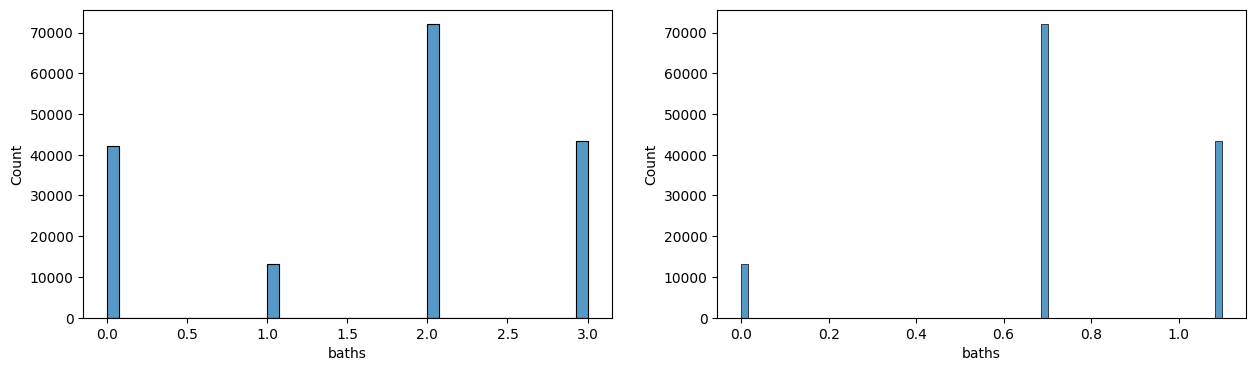

In [319]:
#Строим гистограмму
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df, x='baths', ax=axes[0]);
#Логарифмируем
log_target = np.log(df['baths'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='k', ls='--', lw=2);

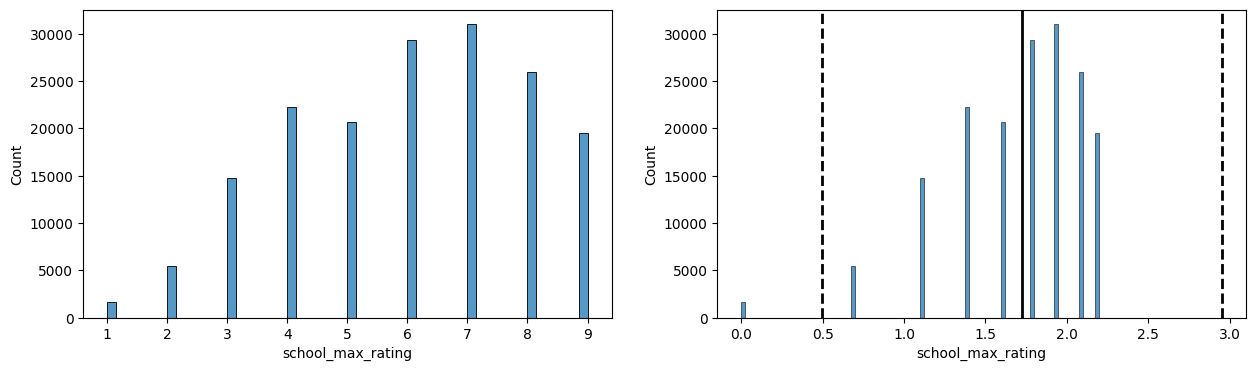

In [320]:
#Строим гистограмму
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df, x='school_max_rating', ax=axes[0]);
#Логарифмируем
log_target = np.log(df['school_max_rating'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='k', ls='--', lw=2);

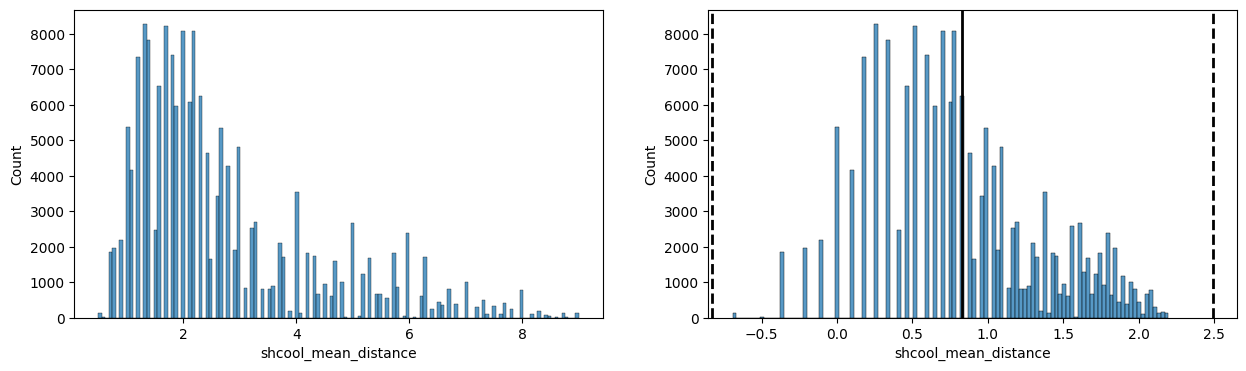

In [321]:
#Строим гистограмму 
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
sns.histplot(data=df, x='shcool_mean_distance', ax=axes[0]);
#Логарифмируем
log_target = np.log(df['shcool_mean_distance'])
#Строим гистограмму в логарифмическом масштабе
sns.histplot(data=log_target, ax=axes[1]);
#Добавляем вертикальные линии для среднего и 3ех стандартных отклонений влево и вправо от среднего
axes[1].axvline(log_target.mean(), color='k', lw=2)
axes[1].axvline(log_target.mean()+ 3 *log_target.std(),
                color='k', ls='--', lw=2)
axes[1].axvline(log_target.mean()- 3 *log_target.std(),
                color='k', ls='--', lw=2);

Избавимся от выбросов с помощью метода z-отклонений на логарифмированных признаках. 

In [322]:
#Объявляем функцию, реализующую фильтрацию выбросов по методу z-отклонений
def outliers_z_score(data, feature, log_scale=False):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - 3 * sigma
    upper_bound = mu + 3 * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x > lower_bound) & (x < upper_bound)]
    return outliers, cleaned
#Производим очистку 
outliers, temp_cleaned = outliers_z_score(df, 'target', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'sqft', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'baths', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'school_max_rating', log_scale=True)
outliers, temp_cleaned = outliers_z_score(temp_cleaned, 'shcool_mean_distance', log_scale=True)
print('Shape before cleaning outliers: {}'.format(df.shape))
print('Shape after cleaning outliers: {}'.format(temp_cleaned.shape))

Shape before cleaning outliers: (170655, 22)
Shape after cleaning outliers: (165481, 22)


In [325]:
# выведем информацию о получившимся датафрейме
temp_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 165481 entries, 0 to 377177
Data columns (total 22 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   status                165481 non-null  object 
 1   propertyType          165481 non-null  object 
 2   street                165481 non-null  object 
 3   baths                 165481 non-null  float64
 4   fireplace             165481 non-null  object 
 5   city                  165481 non-null  object 
 6   sqft                  165481 non-null  int32  
 7   zipcode               165481 non-null  int32  
 8   state                 165481 non-null  object 
 9   stories               165481 non-null  float64
 10  target                165481 non-null  int32  
 11  pool                  165481 non-null  object 
 12  school_max_rating     165481 non-null  float64
 13  school_mean_rating    165481 non-null  float64
 14  school_mini_distance  165481 non-null  float64
 15  shcoo

In [326]:
# Сохраним полученный датафрейм в CSV-файл
temp_cleaned.to_csv("data/clean_df.csv", index=False)